<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/feature-engineering/notebooks/3.0a-mb-explanatory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gcsfs==2022.10.0
!pip install scikit-learn==1.1.3
!pip install pandas-datareader==0.10.0
!pip install seaborn==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 18.1 MB/s 
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.11.0
    Uninstalling fsspec-2022.11.0:
      Successfully uninstalled fsspec-2022.11.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.2 MB 1.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 19.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader

In [2]:
import os
import random

import dateutil.relativedelta as relativedelta

import gcsfs
import google.auth
from google.colab import auth

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web

from scipy import stats

import seaborn as sns
from typing import Any, List, Optional, Union


In [3]:
# set N used in n-largest or smallest
N = 10


In [4]:
# set style
plt.style.use("seaborn-notebook")

# set ratio of figure
ratio = (16, 9)


In [5]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"


In [6]:
# set fixed seed
def seed_everything(seed) -> None:
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    # pandas and numpy as discussed here: https://stackoverflow.com/a/52375474/5755604
    np.random.seed(seed)


seed = 42
seed_everything(seed)


This notebook performs an eda on the training set only to avoid data leakage. ⚠️

In [7]:
data = pd.read_parquet("gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet")

In [8]:
data = data.sample(frac=0.001, axis=0, random_state=seed)

## Notes on data set 🗃️

**Overview on ticker symbols:**
- `others` identified by issue type.
- 5th letter has a special meaning as found in [this table](https://en.wikipedia.org/wiki/Ticker_symbol):

| Letter                  | Letter contd.              | Letter contd.                                    |
|--------------------------------|-------------------------------------|------------------------------------------------|
| A – Class "A"                  | K – Nonvoting (common)              | U – Units                                      |
| B – Class "B"                  | L – Miscellaneous                   | V – Pending issue and distribution             |
| C – NextShares                 | M – fourth class – preferred shares | W – Warrants                                   |
| D – New issue or reverse split | N – third class – preferred shares  | X – Mutual fund                                |
| E – Delinquent SEC filings     | O – second class – preferred shares | Y – American depositary receipt (ADR)          |
| F – Foreign                    | P – first class preferred shares    | Z – Miscellaneous situations                   |
| G – first convertible bond     | Q – In bankruptcy                   | Special codes                                  |
| H – second convertible bond    | R – Rights                          | PK – A Pink Sheet, indicating over-the-counter |
| I – third convertible bond     | S – Shares of beneficial interest   | SC – Nasdaq Small Cap                          |
| J – Voting share – special     | T – With warrants or rights         | NM – Nasdaq National Market                    |


**Coverage:**

*	Options on U.S. listed Stock, ETFs, and Indices disseminated over the Options Price Reporting Authority (OPRA) market data feed 
*	Global Trading Hours (GTH) trades are included if between 03:00am-09:15am U.S. Eastern, and for the 16:15pm 17:00pm Curb session.  GTH trades outside of these time ranges will *not* be included. 

Found [here.](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf)

**Exchange Identifier:**

- 5 = Chicago Board Options Exchange (CBOE)
- 6 = International Securities Exchange (ISE)

Found [here.](https://datashop.cboe.com/documents/livevol_exchange_ids.csv)


**Issue Types:**

Issue Type = the type of security: 
- 0 = Common Stock 
- A = Market index 
- 7 = Mutual or investment trust fund 
- F = ADR/ADS 
- % = Exchange-traded fund 
- (blank) = Unspecified

Received from supervisor.

Adapted from the cboe data shop found at [option trades](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf) and [option quotes](https://datashop.cboe.com/documents/Option_Quotes_Layout.pdf).

|     Column Label                                                          |     Data   Type     |     Description                                                                                                                                                                                                         |
|---------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     underlying_symbol                                                     |     string          |     The underlying stock or index.  An index will utilize a caret (^) prefix,   i.e. ^NDX,^SPX,^VIX…etc.  Underlyings   with classes may utilize a dot (.) instead of a slash or space, i.e. BRK.B,   RDS.A, RDS.B.     |
|     quote_datetime                                                        |     datetime        |     The trading date and timestamp of the trade in   U.S. Eastern time. Ex:  yyyymm-dd   hh:mm:ss.000                                                                                                                   |
|     sequence_number                                                       |     integer         |     Trade Sequence Number for the execution reported   by OPRA                                                                                                                                                          |
|     root                                                                  |     string          |     The option trading class symbol.  Non-standard roots may end with a digit                                                                                                                                           |
|     expiration                                                            |     date            |     The explicit expiration date of the option:   yyyy-mm-dd                                                                                                                                                            |
|     strike                                                                |     numeric         |     The exercise/strike price of the option                                                                                                                                                                             |
|     option_type                                                           |     string          |     C for Call options, P for Put options                                                                                                                                                                               |
|     exchange_id                                                           |     integer         |     An identifier for the options exchange the trade   was executed on.  For a mapping, please   see Exchange ID   Mappings                                                                                             |
|     trade_size                                                            |     integer         |     The trade quantity                                                                                                                                                                                                  |
|     trade_price                                                           |     numeric         |     The trade price                                                                                                                                                                                                     |
|     trade_condition_id                                                    |     integer         |     The trade or sale condition of the execution.  For a mapping, please see Trade   Condition ID Mapping                                                                                                               |
|     canceled_trade_condition_id                                           |     integer         |     This field is no longer supported and will default   to 0 (zero).  See IDs 40-43 in the   Trade Condition ID Mapping file above                                                                                     |
|     best_bid                                                              |     numeric         |     The best bid price (NBB) at the time of the trade                                                                                                                                                                   |
|     best_ask                                                              |     numeric         |     The best ask/offer price (NBO) at the time of the   trade                                                                                                                                                           |
|     bid_size              |     integer         |     The largest size from an options exchange   participant on the best bid price (NBB)                                                                                                                                   |
|     bid                   |     numeric         |     The best bid price (NBB) at the interval time   stamp                                                                                                                                                                 |
|     ask_size              |     integer         |     The largest size from an options exchange   participant on the best offer price (NBO)                                                                                                                                 |
|     ask                   |     numeric         |     The best offer price (NBO) at the interval time   stamp                                                                                                                                                               |

## Dtypes, distributions, and memory consumption 🔭

In [9]:
data.head()


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,issue_type,myn,buy_sell
3249281,2006-09-06 15:15:23,YNU,2008-01-19,5.0,C,5,2.05,1.95,2.05,2.05,...,186.0,1.90,2.20,26165240.0,5.0,2.20,2.20,0,1.225000,1
11026460,2009-01-30 14:21:48,UFB,2009-05-16,22.5,P,5,5.30,5.20,5.30,5.30,...,5.0,5.10,4.90,46287840.0,5.0,4.90,4.00,0,1.119125,-1
11754654,2009-04-06 13:43:46,UZK,2009-04-18,55.0,C,1,0.20,0.10,0.20,0.20,...,307.0,0.15,0.15,45632176.0,1.0,0.12,0.07,0,0.837000,1
12792033,2009-07-07 09:46:26,ASJ,2009-09-19,16.0,C,1,3.00,2.95,3.00,3.00,...,10.0,2.70,2.65,46669576.0,10.0,2.70,3.90,0,1.068437,-1
27061954,2013-04-09 11:29:28,GG,2013-04-20,36.0,P,1,3.71,3.65,3.75,3.75,...,21.0,3.65,4.80,83130448.0,2.0,3.65,2.81,0,1.111969,1


In [10]:
data.describe()


,STRK_PRC,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,myn,buy_sell
count,29510.000000,29510.000000,29510.000000,29510.000000,29510.000000,29175.000000,29175.000000,29175.000000,29175.000000,28611.000000,28960.000000,29484.0,29510.000000,27484.000000,27813.000000,29466.000000,29510.000000
mean,76.815475,14.735310,4.918667,4.822881,5.005740,5.040519,4.831630,338.720734,350.942932,4.948311,4.942775,50265100.0,69.360725,4.937222,4.971466,0.985127,-0.053609
std,194.151672,58.811358,15.108210,15.033523,15.178104,15.256664,15.095028,1322.856689,1293.236694,14.561021,14.984590,22208306.0,362.242249,14.691357,15.101578,0.430581,0.998579
min,0.500000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,21058548.0,1.000000,0.010000,0.010000,0.064875,-1.000000
25%,22.000000,2.000000,0.550000,0.500000,0.580000,0.600000,0.500000,22.000000,26.000000,0.560000,0.560000,32800524.0,4.000000,0.570000,0.600000,0.863786,-1.000000
50%,40.000000,5.000000,1.750000,1.690000,1.800000,1.800000,1.680000,71.000000,79.000000,1.790000,1.790000,45687824.0,10.000000,1.750000,1.800000,0.959056,-1.000000
75%,65.000000,10.000000,4.600000,4.500000,4.700000,4.750000,4.500000,254.000000,278.000000,4.650000,4.600000,62471088.0,40.000000,4.600000,4.620000,1.055643,1.000000
max,3315.000000,4500.000000,1182.500000,1181.300049,1182.500000,1182.500000,1181.099976,91599.000000,99294.000000,1180.500000,1115.500000,109078208.0,29500.000000,1180.500000,1115.500000,46.880001,1.000000


In [11]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29510 entries, 3249281 to 28127043
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   QUOTE_DATETIME  29510 non-null  datetime64[ns]
 1   ROOT            29510 non-null  object        
 2   EXPIRATION      29510 non-null  datetime64[ns]
 3   STRK_PRC        29510 non-null  float32       
 4   OPTION_TYPE     29510 non-null  category      
 5   TRADE_SIZE      29510 non-null  int64         
 6   TRADE_PRICE     29510 non-null  float32       
 7   BEST_BID        29510 non-null  float32       
 8   BEST_ASK        29510 non-null  float32       
 9   ask_ex          29175 non-null  float32       
 10  bid_ex          29175 non-null  float32       
 11  bid_size_ex     29175 non-null  float32       
 12  ask_size_ex     29175 non-null  float32       
 13  price_all_lead  28611 non-null  float32       
 14  price_all_lag   28960 non-null  float32      

In [12]:
print(data.shape)


(29510, 22)


In [13]:
print(data.shape)
# drop identical rows, if present
data.drop_duplicates(inplace=True)
print(data.shape)


(29510, 22)
(29509, 22)


**Observation:**
- Shape matches the shape reported in table 1 (panel A) of Grauer et al. paper.
- No duplicates

In [14]:
data.nunique()


QUOTE_DATETIME    29480
ROOT               4421
EXPIRATION          263
STRK_PRC            569
OPTION_TYPE           2
TRADE_SIZE          319
TRADE_PRICE        2405
BEST_BID           1433
BEST_ASK           1455
ask_ex             1464
bid_ex             1417
bid_size_ex        2435
ask_size_ex        2477
price_all_lead     2164
price_all_lag      2153
optionid          28239
day_vol             928
price_ex_lead      2271
price_ex_lag       2297
issue_type            5
myn               25052
buy_sell              2
dtype: int64

In [15]:
data.head().T


,3249281,11026460,11754654,12792033,27061954
QUOTE_DATETIME,2006-09-06 15:15:23,2009-01-30 14:21:48,2009-04-06 13:43:46,2009-07-07 09:46:26,2013-04-09 11:29:28
ROOT,YNU,UFB,UZK,ASJ,GG
EXPIRATION,2008-01-19 00:00:00,2009-05-16 00:00:00,2009-04-18 00:00:00,2009-09-19 00:00:00,2013-04-20 00:00:00
STRK_PRC,5.0,22.5,55.0,16.0,36.0
OPTION_TYPE,C,P,C,C,P
TRADE_SIZE,5,5,1,1,1
TRADE_PRICE,2.05,5.3,0.2,3.0,3.71
BEST_BID,1.95,5.2,0.1,2.95,3.65
BEST_ASK,2.05,5.3,0.2,3.0,3.75
ask_ex,2.05,5.3,0.2,3.0,3.75


## Basic features🧸

Analysis of numerical features without any feature engineering.

### Correlations 🎲

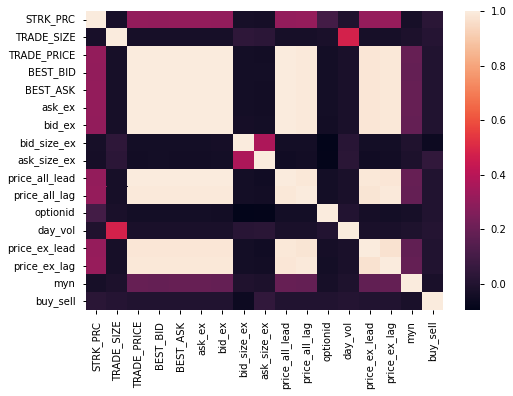

In [16]:
corr: pd.DataFrame = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)  # type: ignore


**Observation:**
* There are many highly correlated columns. The correlations are intuitive e. g., between `price_all_lead` and `price_ex_lead`.
* Few columns show a weak correlation with target (see also below).

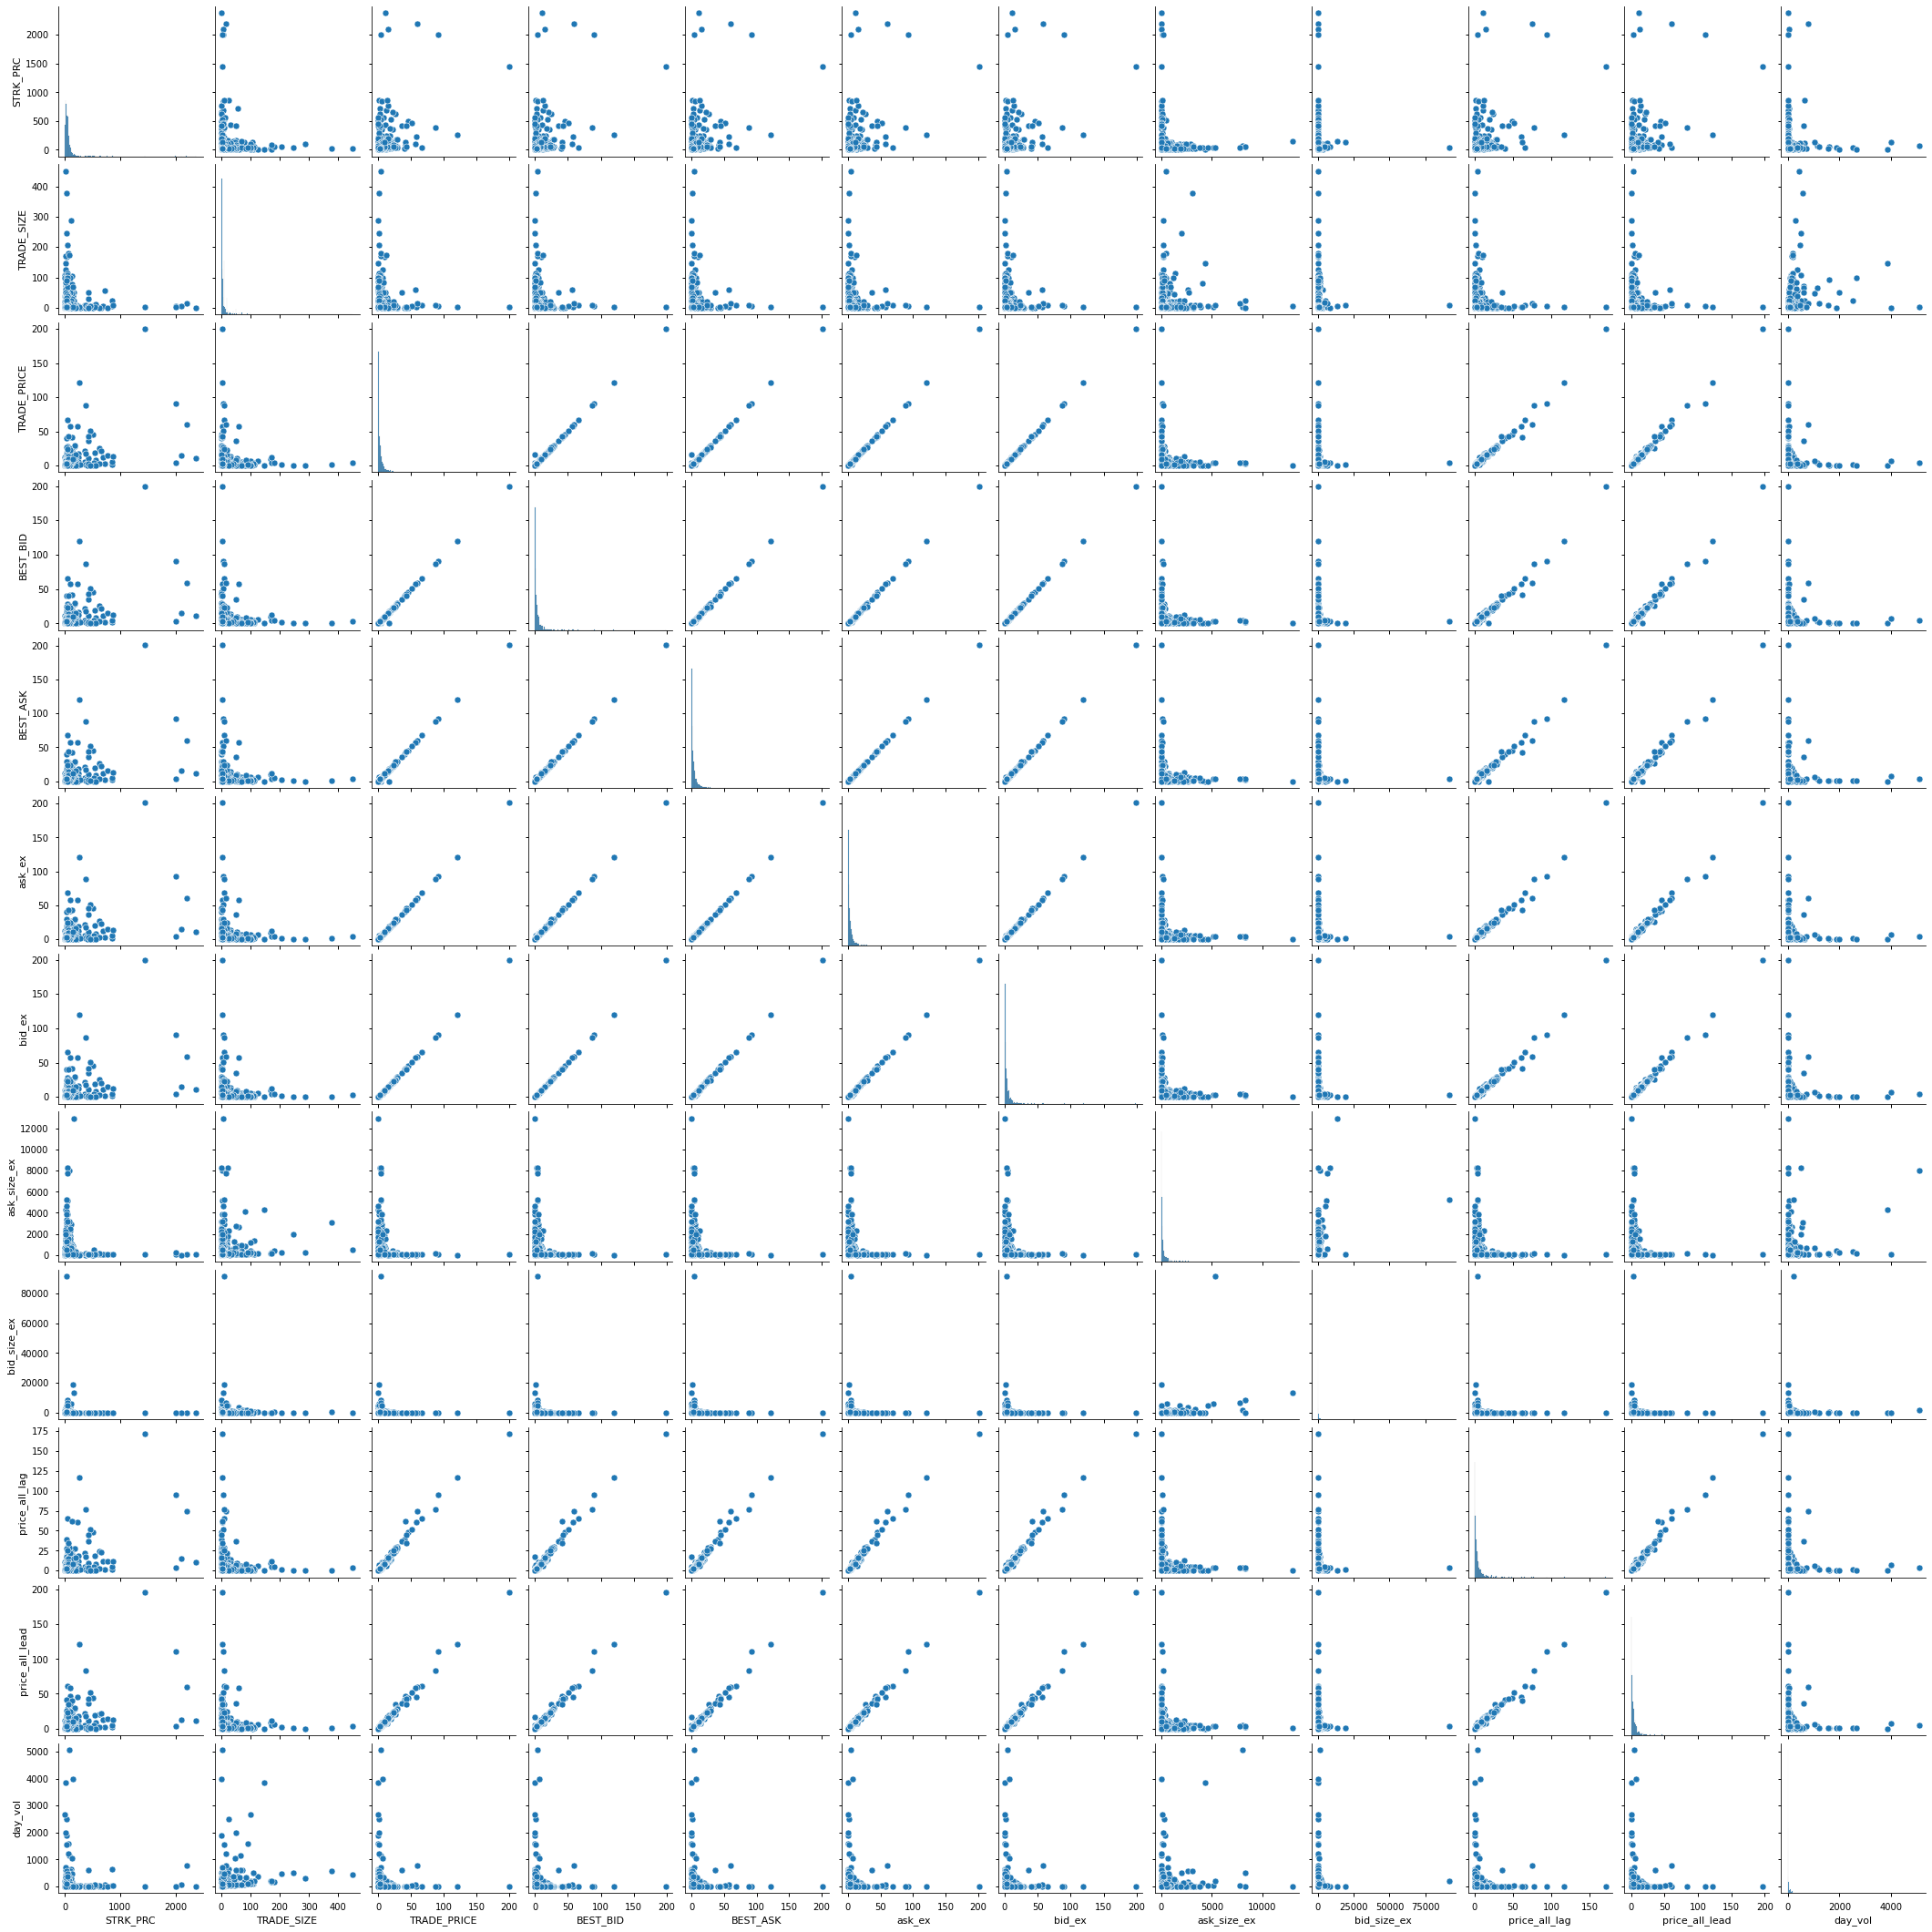

In [17]:
sample = data.sample(n=1000, random_state=seed)
sns.pairplot(
    sample,
    vars=[
        "STRK_PRC",
        "TRADE_SIZE",
        "TRADE_PRICE",
        "BEST_BID",
        "BEST_ASK",
        "ask_ex",
        "bid_ex",
        "ask_size_ex",
        "bid_size_ex",
        "price_all_lag",
        "price_all_lead",
        "day_vol",
    ],
)


### Correlation with target 🎲

In [18]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()


,buy_sell
buy_sell,1.000000
bid_size_ex,-0.057711
ask_size_ex,0.045940
STRK_PRC,0.024632
myn,-0.020026
TRADE_SIZE,0.012506
day_vol,0.008866
TRADE_PRICE,0.001642
price_ex_lead,0.001528
price_all_lag,0.000816


**Observation:**
* Overall correlations are relatively low. Typical for financial data due to low signal-to-noise ratio.
* Size-related features like `ask_size_ex` or `bid_size_ex` have the highest correlation with the target. Thus, can be promising to be included in the model. Consider size features when constructing feature sets.
* Features like `optionid`, `order_id`, and `SEQUENCE_NUMBER` are also among the features with the highest correlations. Remove them, as the correlation is misleading.

In [19]:
# remove some columns, which will NOT be used in model
data.drop(columns=["optionid"], inplace=True)


### Collinearity of features 🎲

In [20]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good
threshold = 0.975
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.975
to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]

print(to_drop)


['BEST_BID', 'BEST_ASK', 'ask_ex', 'bid_ex', 'price_all_lead', 'price_all_lag', 'price_ex_lead', 'price_ex_lag']


**Observation:**
- Columns suggested for removal are intuitive
- Do not blindly remove columns, but preserve a pattern or groups

In [21]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])


In [22]:
pd.Series(above_threshold_vars)


STRK_PRC                                                 [STRK_PRC]
TRADE_SIZE                                             [TRADE_SIZE]
TRADE_PRICE       [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
BEST_BID          [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
BEST_ASK          [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
ask_ex            [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
bid_ex            [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
bid_size_ex                                           [bid_size_ex]
ask_size_ex                                           [ask_size_ex]
price_all_lead    [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
price_all_lag     [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
optionid                                                 [optionid]
day_vol                                                   [day_vol]
price_ex_lead     [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
price_ex_lag      [TRADE_PRICE, BEST_BID, BEST_A

**Observations:**
* Some columns are highly correlated. This is very intuitive.
* It seems problematic to include both `BEST_BID` and `bid_ex`. This is also true for `BEST_ASK` and `ask_ex`. `price_all_lead` and `price_all_lag` seem to be less problematic.
* Define feature sets so that the number of highly correlated variables is minimized. But maintain groups so that a comparsion with classical rules is still possible.

## Preparation 🥗

### Time features ⏰

In [23]:
# apply positional encoding to dates
data["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
data["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

# time (daily)
seconds_in_day = 24 * 60 * 60
seconds = (
    data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()
).dt.total_seconds()

data["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
data["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

# year min-max scaled
data["date_year_min"] = (data["QUOTE_DATETIME"].dt.year - 2005) / (2017 - 2005)

# time to maturity
data["ttm"] = (
    data["EXPIRATION"].dt.to_period("M") - data["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)

# day, month and year
data["day"] = data["QUOTE_DATETIME"].dt.day
data["month"] = data["QUOTE_DATETIME"].dt.month
data["year"] = data["QUOTE_DATETIME"].dt.year
data["date"] = data["QUOTE_DATETIME"].dt.date


### Binned features 🥫

Bin features similarily to how they are used in the robustness tests.

In [24]:
bins_tradesize = [0, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
data["TRADE_SIZE_binned"] = pd.cut(
    data["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2004, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
data["year_binned"] = pd.cut(data["year"], bins_years, labels=year_labels)

bins_ttm = [-1, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
data["ttm_binned"] = pd.cut(data["ttm"], bins_ttm, labels=ttm_labels)


### Trade features 💴
Construct features that are used in classical rules.

In [25]:
# spread in $ between ask and bid
data["spread_ex"] = data["ask_ex"] - data["bid_ex"]

# Calculate change similar to tick rule
data["chg_lead_ex"] = data["TRADE_PRICE"] - data["price_ex_lead"]

# Calculate change similar to reverse tick rule
data["chg_lag_ex"] = data["TRADE_PRICE"] - data["price_ex_lag"]

# Midspread
mid_ex = 0.5 * (data["ask_ex"] + data["bid_ex"])
mid_best = 0.5 * (data["BEST_ASK"] + data["BEST_BID"])

# ratio of bid-ask
data["bid_ask_ratio_ex"] = data["bid_ex"] / data["ask_ex"]

# Absolute distance from mid
data["abs_mid_ex"] = data["TRADE_PRICE"] - mid_ex
data["mid_ex"] = mid_ex

# Absolute distance from mid
data["abs_mid_BEST"] = data["TRADE_PRICE"] - mid_best
data["mid_best"] = mid_best

# depth rule (usually only applied to mid spread transactions)
data["bid_ask_size_ratio_ex"] = data["bid_size_ex"] / data["ask_size_ex"]

# Degree how much trade size is filled -> similar to trade size rule
# Trade size rule would just classify if
data["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
data["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]

# EMO / CLNV
data["rel_ask_ex"] = (data["TRADE_PRICE"] - mid_ex) / (data["ask_ex"] - mid_ex)
data["rel_bid_ex"] = (mid_ex - data["TRADE_PRICE"]) / (mid_ex - data["bid_ex"])

# EMO / CLNV
data["BEST_rel_bid"] = (data["TRADE_PRICE"] - mid_best) / (data["BEST_ASK"] - mid_best)
data["BEST_rel_ask"] = (mid_best - data["TRADE_PRICE"]) / (mid_best - data["BEST_BID"])


### Underlying features 🫀

In [134]:
data["symbol_is_index"] = data["ROOT"].str.startswith("^").astype(int)


# TODO: Add majority class @ day


### Categorical features 🎰

### Visualization helper 🐜

In [27]:
def plot_kde_target(var_name: str, clip: Optional[List[float]] = None):
    """
  Plot kde plots for buys (+1) and sells (-1) with regard to \
  the feature 'var_name'.

   Args:
      var_name (str): name of the feature
      clip (Optional[List[float]], optional): clipping range. Defaults to None.
  """
    corr_var = data["buy_sell"].corr(data[var_name])

    median_sell = data[data["buy_sell"] == -1][var_name].median()
    median_buy = data[data["buy_sell"] == 1][var_name].median()

    _, ax = plt.subplots()
    for i in [-1, 1]:
        sns.kdeplot(
            data=data[data["buy_sell"] == i],
            x=var_name,
            clip=clip,
            label=str(i),
            cumulative=False,
            common_grid=True,
        )
    ax.title.set_text(f"Distribution of '{var_name}'")
    ax.legend()
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
    plt.show()
    print(
        f"The correlation between '{var_name}' and the 'buy_sell' is {corr_var: 0.4f}"
    )
    print(f"Median value of sells = {median_sell: 0.4f}")
    print(f"Median value of buys = {median_buy: 0.4f}")


In [28]:
def plot_kde_target_comparsion(
    var_name: str,
    clip: Optional[List[float]] = None,
    years: List[int] = [2006, 2010, 2013],
) -> None:
    """
    Plot several kde plots side by side for the feature.

    Args:
        var_name (str): name of the feature
        clip (Optional[List[float]], optional): clipping range. Defaults to None.
        years (List[int], optional): years to compare. Defaults to [2006, 2010, 2013].
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(years), figsize=(18, 4))

    fig.suptitle(f"Distribution of `{var_name}`")

    for y, year in enumerate(years):
        for i in [-1, 1]:
            sns.kdeplot(
                data=data[(data["buy_sell"] == i) & (data["year"] == year)],
                x=var_name,
                clip=clip,
                # supress any other but first label using '_'
                # see https://stackoverflow.com/a/44633022/5755604
                label="_" * y + str(i),
                cumulative=False,
                common_grid=True,
                ax=ax[y],
            )
            ax[y].xaxis.label.set_text(str(year))

    fig.legend()


In [29]:
us_rec = web.DataReader("USREC", "fred", data["date"].min(), data["date"].max())


def plot_recessions() -> None:
    """
    Add recession indicator to plot and entry to legend.
    """
    l = 0
    month = relativedelta.relativedelta(months=+1)
    for date, val in us_rec["USREC"].items():
        if val == 1:
            # if boolean = 1 -> print bar until next month
            # '_' labels are ignored in legend https://stackoverflow.com/a/44633022/5755604
            plt.axvspan(
                date,
                date + month,
                edgecolor="none",
                alpha=0.25,
                label="_" * l + "recession",
            )
            l += 1


In [30]:
def plot_time_series(
    feature: Union[str, List[str]], aggregation: Union[str, List[Any]] = "count"
) -> pd.DataFrame:
    """
    Plot feature over time. Aggregate using 'aggregation'.

    Args:
        feature (Union[str, List[str]]): feature to plot.
        aggregation (Union[str, List[Any]], optional): aggregation operation. Defaults to "count".

    Returns:
        pd.DataFrame: time series
    """
    if isinstance(feature, str):
        feature = [feature]
    if isinstance(aggregation, str):
        aggregation = [aggregation]

    time_series = data[feature].groupby(data["date"]).agg(aggregation)
    time_series.columns = time_series.columns.to_flat_index()

    ax = sns.lineplot(data=time_series)
    ax.yaxis.label.set_text(" / ".join(aggregation))
    ax.title.set_text(f"'{' / '.join(feature)}' over time")
    plot_recessions()
    ax.legend()
    plt.show()

    return time_series


In [31]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = data.select_dtypes(include=["category", "object"]).columns.tolist()
print(cat_columns)

# assign "bin_" column prefix 
cat_columns_bin = ["bin_" + x for x in cat_columns]

# binarize categorical similar to Borisov et al.
data[cat_columns_bin] = data[cat_columns].apply(lambda x: pd.factorize(x)[0])  # type: ignore


['ROOT', 'OPTION_TYPE', 'issue_type', 'date', 'TRADE_SIZE_binned', 'year_binned', 'ttm_binned']


## General overview 🌄

### Trade price and sizes 🤝

#### Trades over time ⌚

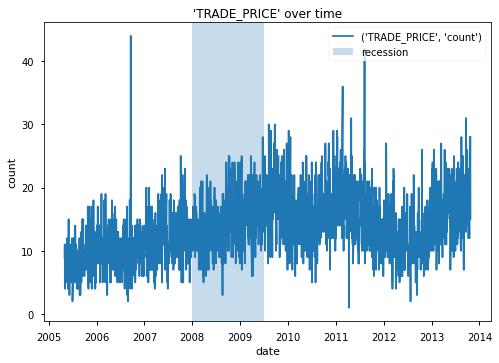

In [32]:
trades_per_day = plot_time_series("TRADE_PRICE", "count")


In [33]:
trades_per_day.iloc[:, 0].nlargest(N)


date
2006-09-19    44
2011-08-08    42
2011-02-22    36
2011-04-28    31
2013-09-20    31
2009-08-07    30
2009-09-22    30
2009-08-24    29
2010-01-06    29
2010-12-13    29
Name: (TRADE_PRICE, count), dtype: int64

In [34]:
trades_per_day.iloc[:, 0].nsmallest(N)


date
2011-04-11    1
2005-07-01    2
2006-08-28    2
2012-07-24    2
2005-06-08    3
2005-08-25    3
2005-08-30    3
2006-03-23    3
2006-08-23    3
2008-08-19    3
Name: (TRADE_PRICE, count), dtype: int64

**Observation:**
* Number of trades increases over time.
* There is no obvious explanation why the number of trades spikes at certain days.

#### Trade size

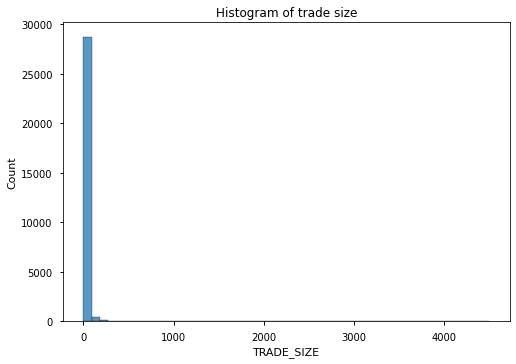

In [35]:
ax = sns.histplot(data, x="TRADE_SIZE", bins=50)  # type: ignore
ax.title.set_text("Histogram of trade size")


**Observation:**
* highly skewed with few outliers.
* Similar to the price, $\log(\cdot)$ transform could help.

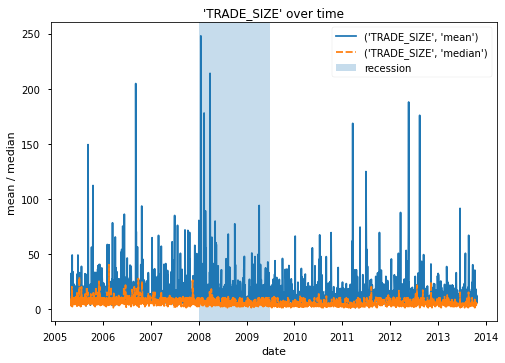

In [36]:
trades_over_time = plot_time_series("TRADE_SIZE", ["mean", "median"])


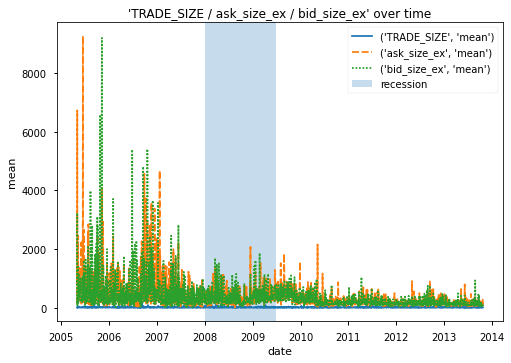

In [37]:
trade_ask_bid_size = plot_time_series(
    ["TRADE_SIZE", "ask_size_ex", "bid_size_ex"], "mean"
)


**Observation:**
* There is a slow downward trend in `TRADE_SIZE` (mean).
* Controversely, the number of trades per day (mean) increases over time.
* Market share of ISE has decrease over time, as reported in https://www.sifma.org/wp-content/uploads/2022/03/SIFMA-Insights-Market-Structure-Compendium-March-2022.pdf. 

In [38]:
data["TRADE_SIZE"].describe()


count    29509.000000
mean        14.735640
std         58.812328
min          1.000000
25%          2.000000
50%          5.000000
75%         10.000000
max       4500.000000
Name: TRADE_SIZE, dtype: float64

In [39]:
data[data["TRADE_SIZE"].max() == data["TRADE_SIZE"]]


,QUOTE_DATETIME,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,ask_ex,...,BEST_rel_bid,BEST_rel_ask,symbol_is_index,bin_ROOT,bin_OPTION_TYPE,bin_issue_type,bin_date,bin_TRADE_SIZE_binned,bin_year_binned,bin_ttm_binned
7284857,2008-01-18 15:51:32,DIW,2008-05-17,60.0,P,4500,2.0,1.99,2.02,2.02,...,-0.333344,0.333339,False,1137,1,1,1162,3,1,1


In [40]:
data.nlargest(N, "TRADE_SIZE", keep="first").T


,7284857,20033263,7494232,24804361,7896509,21111542,7586782,9655736,1043373,3263544
QUOTE_DATETIME,2008-01-18 15:51:32,2011-03-22 15:54:16,2008-02-12 13:56:32,2012-08-14 10:49:14,2008-03-28 13:30:53,2011-07-01 11:50:03,2008-02-22 15:45:55,2008-10-03 13:43:48,2005-10-17 14:29:31,2006-09-08 12:11:06
ROOT,DIW,C,SYH,FCX,NAY,IWM,ALL,SMH,VX,LLY
EXPIRATION,2008-05-17 00:00:00,2011-12-17 00:00:00,2008-06-21 00:00:00,2014-01-18 00:00:00,2008-05-17 00:00:00,2011-10-22 00:00:00,2008-03-22 00:00:00,2009-01-17 00:00:00,2007-01-20 00:00:00,2006-10-21 00:00:00
STRK_PRC,60.0,3.5,160.0,30.0,33.0,63.0,47.5,25.0,10.0,55.0
OPTION_TYPE,P,P,C,C,C,P,C,C,P,P
TRADE_SIZE,4500,3696,2000,2000,1695,1617,1163,1143,1058,1000
TRADE_PRICE,2.0,0.12,0.36,8.37,1.4,0.42,1.25,1.2,0.95,1.35
BEST_BID,1.99,0.11,0.33,8.3,1.4,0.4,1.25,1.17,1.0,1.35
BEST_ASK,2.02,0.12,0.36,8.45,1.5,0.43,1.35,1.2,1.05,1.45
ask_ex,2.02,0.12,0.36,8.45,1.5,0.43,1.35,1.2,1.05,1.45


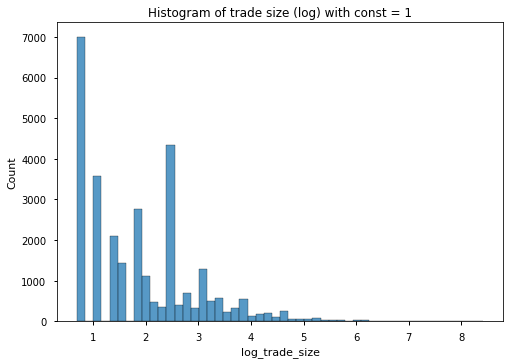

In [41]:
# const not really needed here, due to the trade size being >=1
const = 1
data["log_trade_size"] = np.log(data["TRADE_SIZE"] + const)
ax = sns.histplot(data, x="log_trade_size", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of trade size (log) with const = {const}")


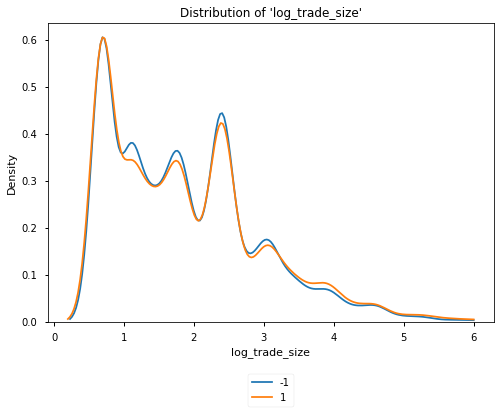

The correlation between 'log_trade_size' and the 'buy_sell' is  0.0104
Median value of sells =  1.7918
Median value of buys =  1.7918


In [42]:
plot_kde_target("log_trade_size", clip=[0, 6])


**Observation:**
- Size features do hardly profit from a $\log$ transform. Might want to keep as-is.

#### Trade price

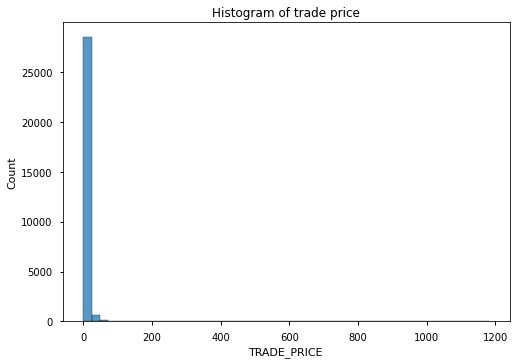

In [43]:
ax = sns.histplot(data, x="TRADE_PRICE", bins=50)  # type: ignore
ax.title.set_text("Histogram of trade price")


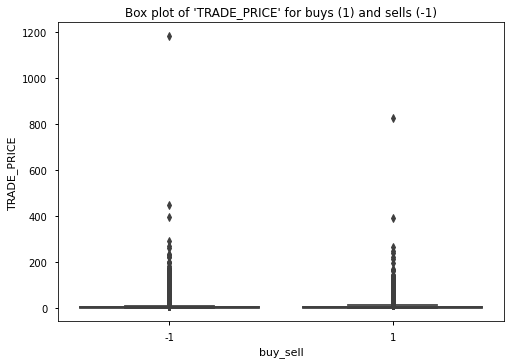

In [44]:
ax = sns.boxplot(data=data, x="buy_sell", y="TRADE_PRICE")
ax.title.set_text("Box plot of 'TRADE_PRICE' for buys (1) and sells (-1)")

**Observations:**
* Very few, very large trade prices, many very small trade prices.
* Scaling can be problematic, if outliers affect scaling much. Try $\log(\cdot)$ transform to correct skewness of distribution. Could improve results.
* Trade price is hardly informative, as distribution is very similar.

In [45]:
const = 1e-2
data["log_trade_price"] = np.log(data["TRADE_PRICE"] + const)


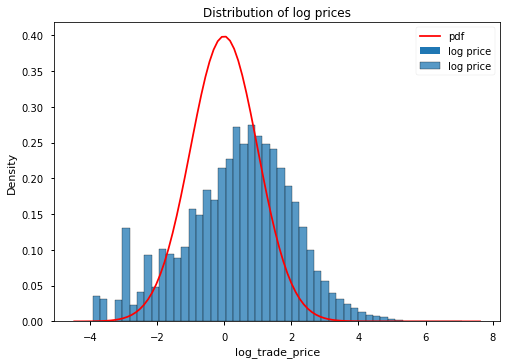

In [46]:
fig, ax = plt.subplots()

sns.histplot(data, x="log_trade_price", bins=50, stat="density", label="log price")  # type: ignore

# extract the limits for the x-axis and fit normal distributon
x0, x1 = ax.get_xlim()
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf)

pdf = pd.DataFrame({"x": x_pdf, "y": y_pdf})
sns.lineplot(data=pdf, x="x", y="y", label="pdf", color="r")


ax.title.set_text("Distribution of log prices")
ax.legend()


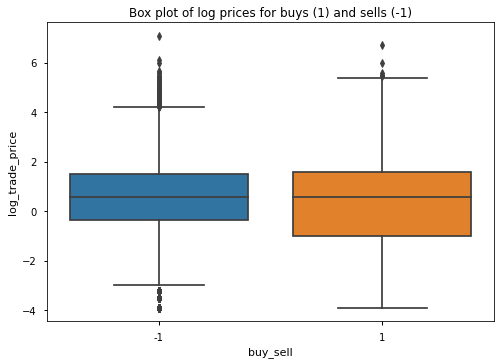

In [47]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_trade_price")
ax.title.set_text("Box plot of log prices for buys (1) and sells (-1)")


In [48]:
data.nlargest(N, "TRADE_PRICE", keep="first").T


,14442297,5376922,9712572,24567800,15649736,7120003,9451355,2625795,4518404,3330782
QUOTE_DATETIME,2009-11-12 09:42:06,2007-06-14 10:56:32,2008-10-08 11:29:25,2012-07-17 10:06:12,2010-03-08 11:23:51,2008-01-03 11:04:05,2008-09-16 10:56:37,2006-06-02 09:31:44,2007-02-28 10:17:05,2006-09-18 13:55:08
ROOT,NDK,NDU,NDY,AAPL,NDV,BDQ,BPJ,GOQ,GOU,NXO
EXPIRATION,2009-12-19 00:00:00,2007-06-16 00:00:00,2008-11-22 00:00:00,2012-07-21 00:00:00,2010-04-17 00:00:00,2008-01-19 00:00:00,2008-09-20 00:00:00,2006-06-17 00:00:00,2007-03-17 00:00:00,2007-12-22 00:00:00
STRK_PRC,600.0,1100.0,1800.0,210.0,1500.0,80.0,540.0,120.0,190.0,1550.0
OPTION_TYPE,C,C,P,C,C,C,P,C,C,C
TRADE_SIZE,10,1,3,1,1,15,10,5,10,1
TRADE_PRICE,1182.5,826.0,447.799988,395.540009,391.320007,292.299988,267.369995,266.5,260.700012,245.0
BEST_BID,1181.300049,826.0,444.100006,395.149994,389.5,292.299988,266.200012,266.200012,260.700012,245.0
BEST_ASK,1182.5,826.200012,451.5,395.649994,393.100006,293.700012,268.799988,266.5,260.899994,247.199997
ask_ex,1182.5,826.200012,451.5,396.25,393.100006,293.700012,268.799988,266.5,260.899994,247.800003


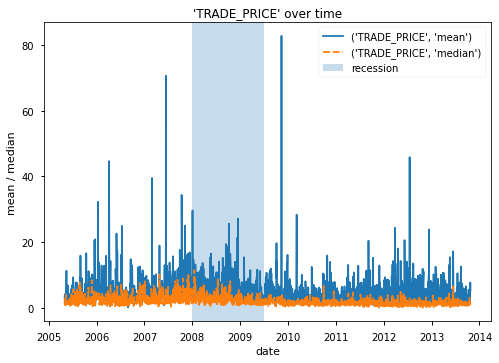

In [49]:
trade_price_over_time = plot_time_series("TRADE_PRICE", ["mean", "median"])


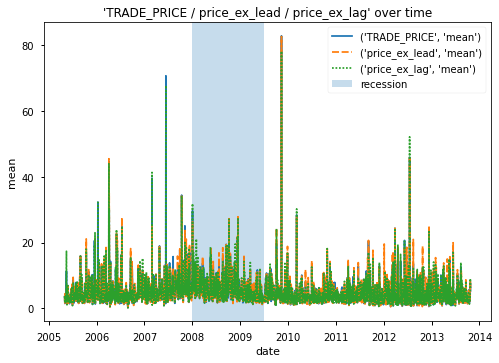

In [50]:
trade_price_over_time = plot_time_series(
    ["TRADE_PRICE", "price_ex_lead", "price_ex_lag"], "mean"
)


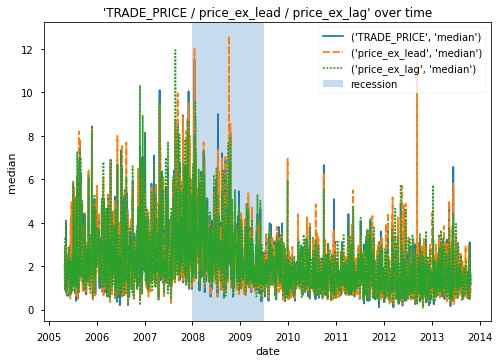

In [51]:
trade_price_over_time = plot_time_series(
    ["TRADE_PRICE", "price_ex_lead", "price_ex_lag"], "median"
)


**Observation:**
* `TRADE_PRICE` remains roughly constant over time. Median decreases over time.
* Large difference between median and mean. 

### Time to maturity ⌚

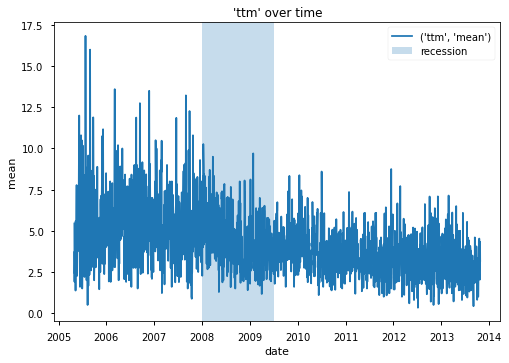

In [52]:
ttm_over_time = plot_time_series("ttm", "mean")


Text(0.5, 0.98, 'Trade Price vs. Time to Maturity')

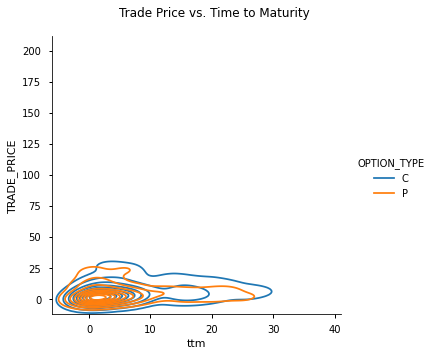

In [53]:
sample = data.sample(n=1000, random_state=seed)

plot = sns.displot(data=sample, x="ttm", y="TRADE_PRICE", kind="kde", hue="OPTION_TYPE")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle("Trade Price vs. Time to Maturity")


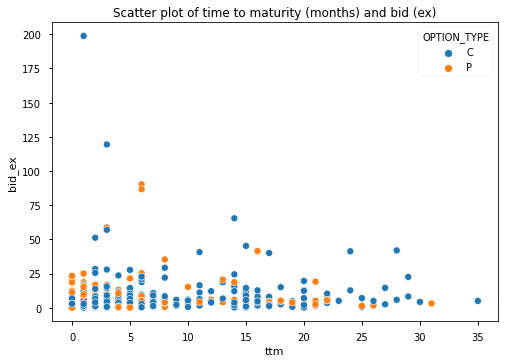

In [54]:
ax = sns.scatterplot(data=sample, x="ttm", y="bid_ex", hue="OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")


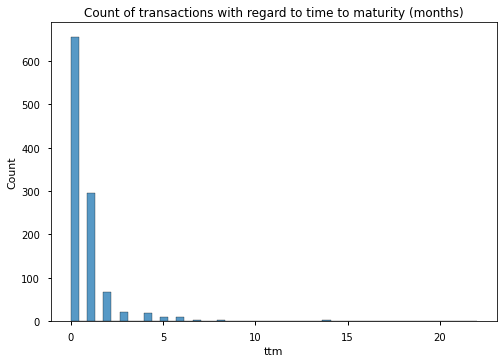

In [55]:
ax = sns.histplot(data=data[data["bid_ex"] == 0.0], x="ttm", bins=50)  # type: ignore
ax.title.set_text("Count of transactions with regard to time to maturity (months)")


**Observation:**
- Most options have a short time-to-maturity
- Binning or cut-off could be helpful

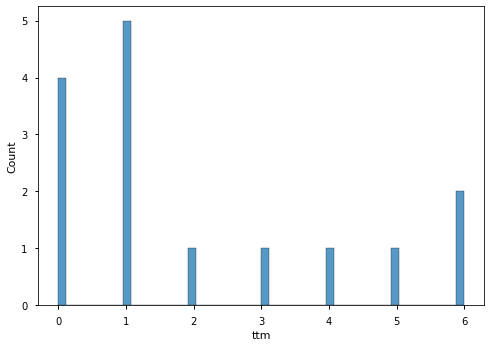

In [56]:
# TODO: ask of zero plausible?
sns.histplot(data=data[data["ask_ex"] == 0.0], x="ttm", bins=50)  # type: ignore


### Strike price

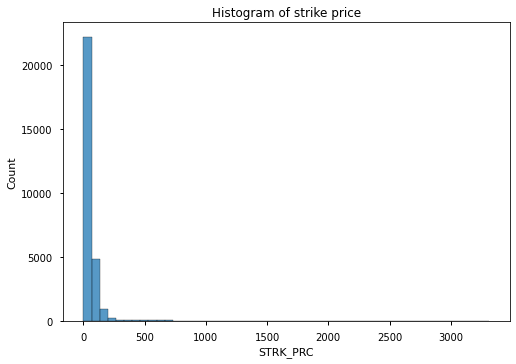

In [57]:
ax = sns.histplot(data, x="STRK_PRC", bins=50)  # type: ignore
ax.title.set_text("Histogram of strike price")


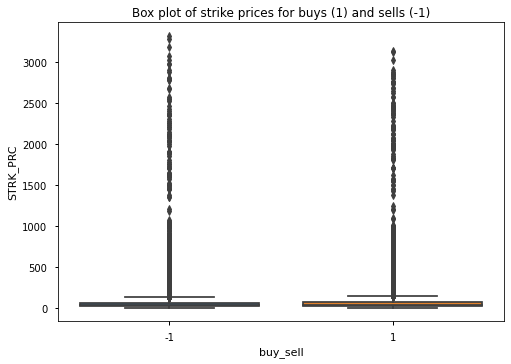

In [58]:
ax = sns.boxplot(data=data, x="buy_sell", y="STRK_PRC")
ax.title.set_text("Box plot of strike prices for buys (1) and sells (-1)")


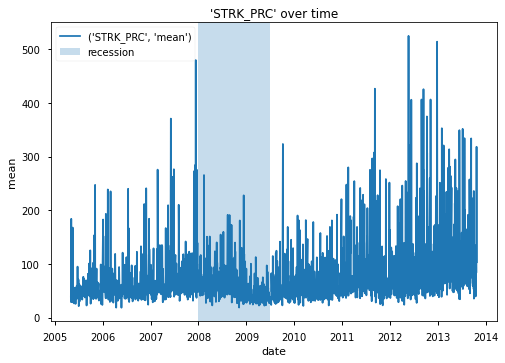

In [59]:
strike_over_time = plot_time_series("STRK_PRC", "mean")


**Observation:**
- Distribution of strike price is highly skewed
- Average strike price grows over time. Thus, very large and previously unobserved trade prices could be part of the test set, but not in the train set.
- Try $\log$

In [60]:
const = 1e-2
data["log_strk_prc"] = np.log(data["STRK_PRC"] + const)


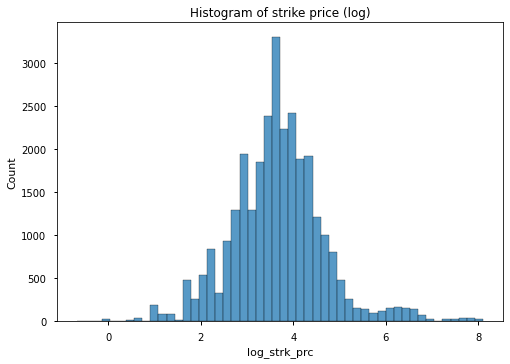

In [61]:
ax = sns.histplot(data, x="log_strk_prc", bins=50)  # type: ignore
ax.title.set_text("Histogram of strike price (log)")


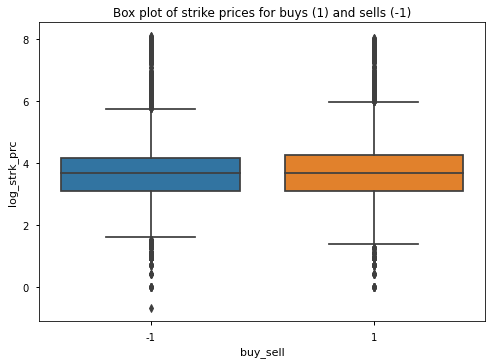

In [62]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_strk_prc")
ax.title.set_text("Box plot of strike prices for buys (1) and sells (-1)")


### Buy Sell 👛

In [63]:
ratio_buy_sell = data["buy_sell"].value_counts() / data["buy_sell"].count()
ratio_buy_sell.head()


-1    0.526788
 1    0.473212
Name: buy_sell, dtype: float64

**Observation:**
* Ratios similar to the one reported in Grauer et. al. Yet not identical as calculation is done on a sample.
* As both classes have a $\approx~0.5$ probability, I would not rebalance. Rebalancing through sampling etc. itself has a bias.
* Ratios seem to be stable over time (see below). Thus, distribution is similar for training, validation, and test set.
* With regard to time-to-maturity the distribution changes slightly for longer periods.

#### By option type

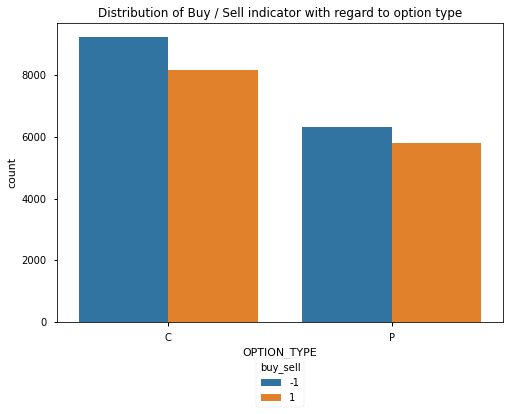

In [64]:
ax = sns.countplot(data=data, x="OPTION_TYPE", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to option type")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))


#### By year

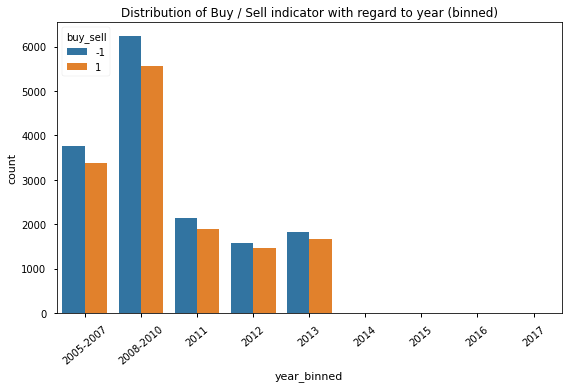

In [65]:
ax = sns.countplot(data=data, x="year_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to year (binned)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()


#### By time time to maturity

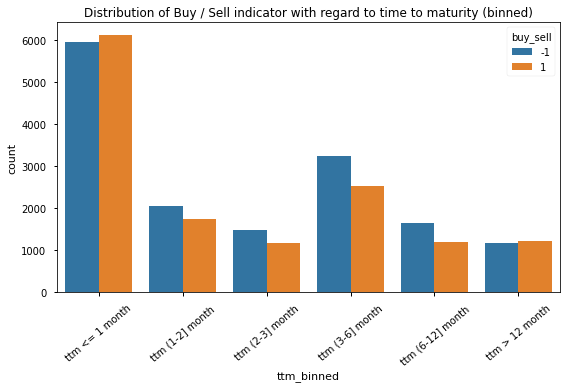

In [66]:
ax = sns.countplot(data=data, x="ttm_binned", hue="buy_sell")
ax.title.set_text(
    "Distribution of Buy / Sell indicator with regard to time to maturity (binned)"
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="center")
plt.tight_layout()
plt.show()


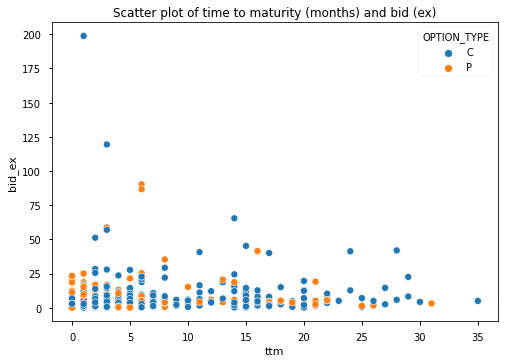

In [67]:
ax = sns.scatterplot(data=sample, x="ttm", y="bid_ex", hue="OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")


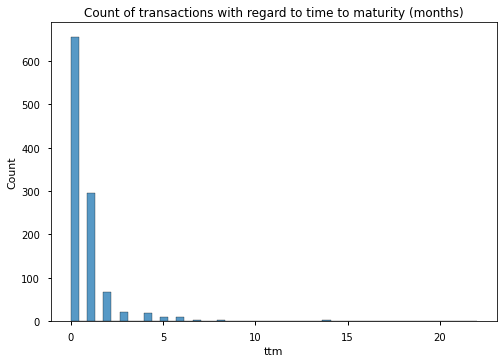

In [68]:
ax = sns.histplot(data=data[data["bid_ex"] == 0.0], x="ttm", bins=50)  # type: ignore
ax.title.set_text("Count of transactions with regard to time to maturity (months)")


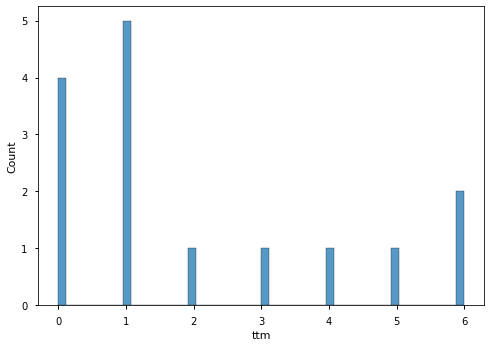

In [69]:
# TODO: ask of zero plausible?
sns.histplot(data=data[data["ask_ex"] == 0.0], x="ttm", bins=50)  # type: ignore


#### Over time

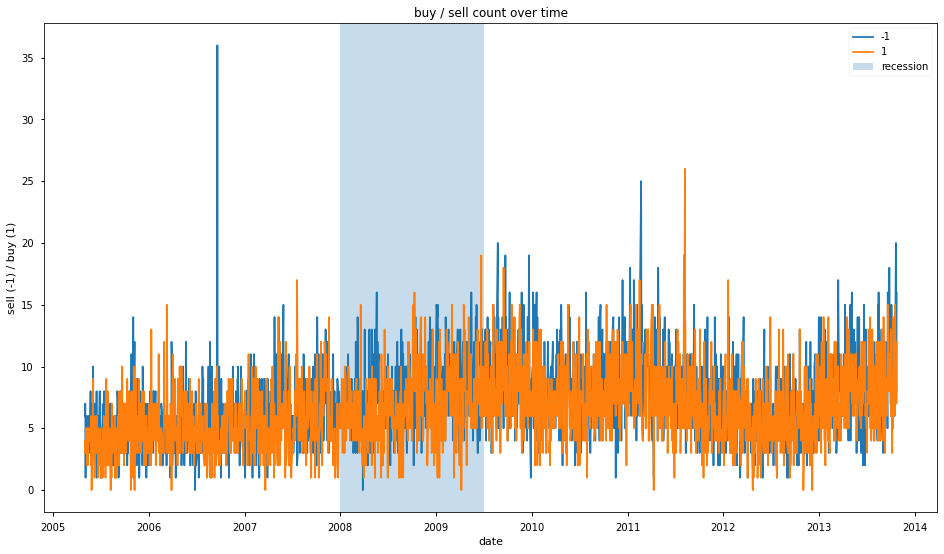

In [70]:
trades_over_time = (
    data.groupby(data["date"])["buy_sell"].value_counts().unstack(fill_value=0)
)
ax = trades_over_time.plot(
    kind="line",
    figsize=ratio,
    title="buy / sell count over time",
    xlabel="date",
    ylabel="sell (-1) / buy (1)",
)
plot_recessions()
ax.legend()
plt.show()


### $n$ most frequent symbols, indices, and special codes 🔢

,Symbol,Count
0,SPY,286
1,GLD,217
2,AAPL,198
3,IWM,149
4,RUT,132
5,NDX,115
6,DIA,112
7,GOOG,108
8,QQQ,108
9,GDX,107


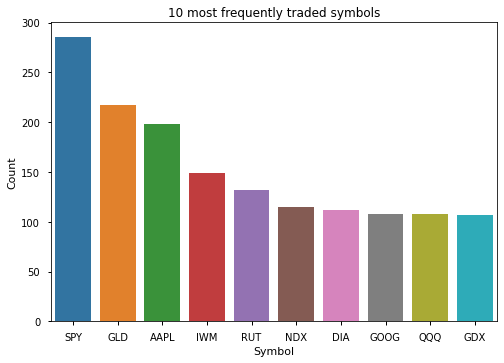

In [71]:
most_frequent_symbols = data["ROOT"].value_counts().head(N).reset_index(name="Count")
most_frequent_symbols.rename(columns={"index": "Symbol"}, inplace=True)

ax = sns.barplot(data=most_frequent_symbols, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded symbols")

most_frequent_symbols.head(N)


In [72]:
list_freq_symbols = most_frequent_symbols.Symbol.tolist()


In [73]:
frequent_symbols_over_time = data[data["ROOT"].isin(list_freq_symbols)]


In [74]:
frequent_symbols_trades_per_day = (
    frequent_symbols_over_time.groupby(
        [frequent_symbols_over_time.QUOTE_DATETIME.dt.to_period("m"), "ROOT"]
    )["TRADE_SIZE"]
    .count()
    .reset_index()
    .rename(columns={"TRADE_SIZE": "count", "QUOTE_DATETIME": "date", "ROOT": "Symbol"})
)


In [75]:
frequent_symbols_over_time = (
    frequent_symbols_trades_per_day.groupby(["date", "Symbol"])["count"]
    .first()
    .unstack()
)


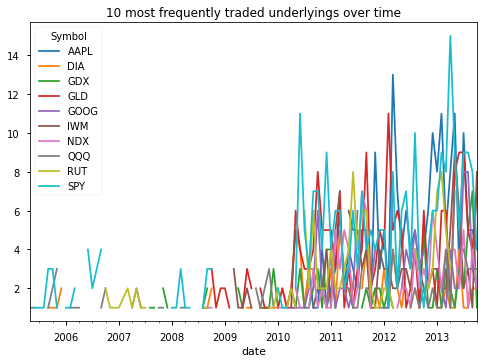

In [76]:
frequent_symbols_over_time.plot(
    kind="line", title=f"{N} most frequently traded underlyings over time"
)


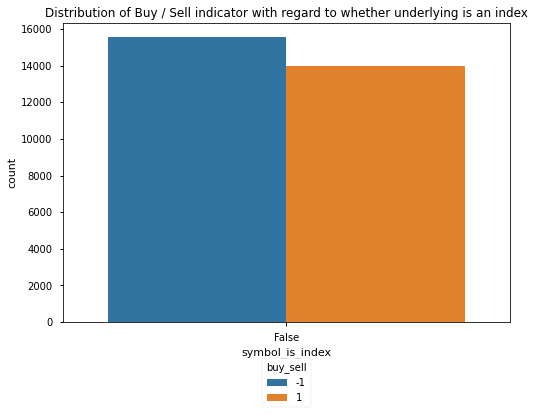

In [77]:
# TODO: investigate why there is no True group
ax = sns.countplot(data=data, x="symbol_is_index", hue="buy_sell")
ax.title.set_text(
    "Distribution of Buy / Sell indicator with regard to whether underlying is an index"
)
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))


In [78]:
ratios_is_index = (
    data.groupby(["symbol_is_index", "buy_sell"])["buy_sell"].count()
    / data.groupby(["symbol_is_index"])["buy_sell"].count()
)
ratios_is_index.head()


symbol_is_index  buy_sell
False            -1          0.526788
                  1          0.473212
Name: buy_sell, dtype: float64

**Observation:**
- Feature can be important, as it's much more likely for trade to be sell, rather than buy, if and only if the underlying is no index option.
- Difference isn't too pronounced and could be due to sampling effects.

In [79]:
data["issue_type"].value_counts(dropna=False)


0      22471
%       4782
F       1778
A        432
NaN       30
7         16
Name: issue_type, dtype: int64

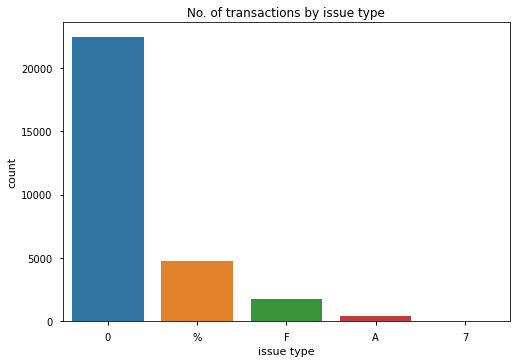

In [80]:
ax = sns.countplot(data=data, x="issue_type")
ax.title.set_text("No. of transactions by issue type")
ax.xaxis.label.set_text("issue type")


###  Ask and bid👨‍⚖️

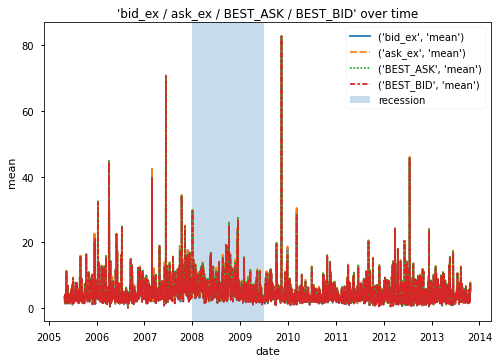

In [81]:
bid_ask_over_time = plot_time_series(
    ["bid_ex", "ask_ex", "BEST_ASK", "BEST_BID"], "mean"
)


#### Ask

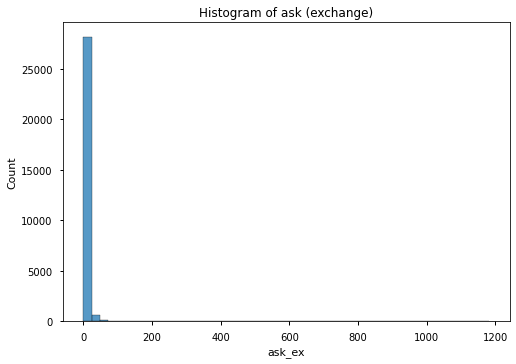

In [82]:
ax = sns.histplot(data, x="ask_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of ask (exchange)")


**Observation:**
* Distribution is highly skewed, try correction with $\log$

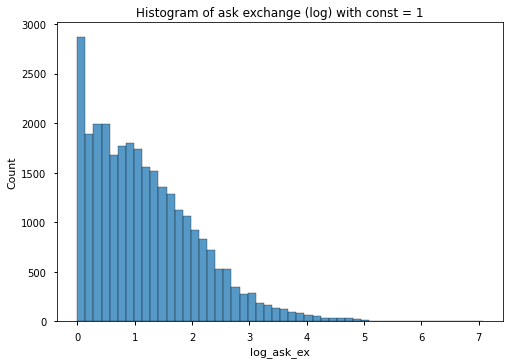

In [83]:
const = 1
data["log_ask_ex"] = np.log(data["ask_ex"] + const)
ax = sns.histplot(data, x="log_ask_ex", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of ask exchange (log) with const = {const}")


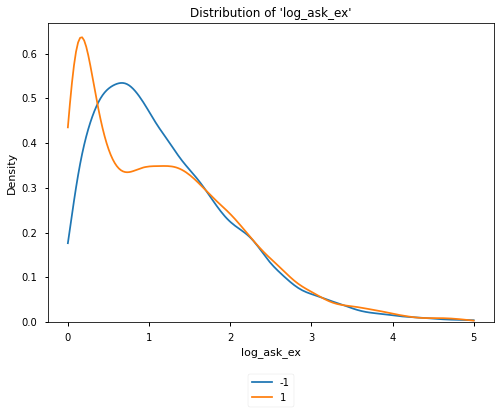

The correlation between 'log_ask_ex' and the 'buy_sell' is -0.0302
Median value of sells =  1.0473
Median value of buys =  1.0296


In [84]:
plot_kde_target("log_ask_ex", clip=[0, 5])


**Observation:**
* Applying a $\log$ transform leads to a easily distinguishable distribution

#### Bid

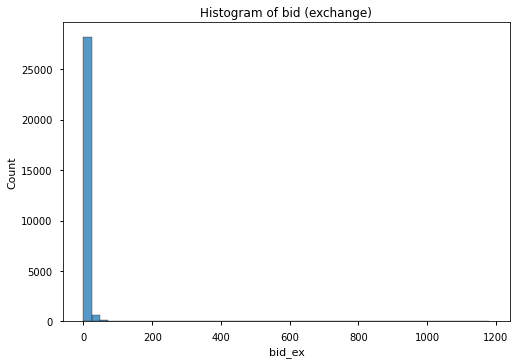

In [85]:
ax = sns.histplot(data, x="bid_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of bid (exchange)")


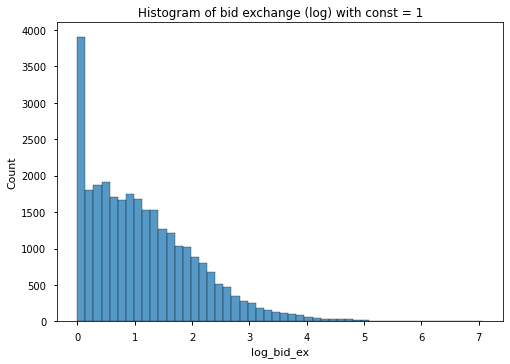

In [86]:
const = 1
data["log_bid_ex"] = np.log(data["bid_ex"] + const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)  # type: ignore
ax.title.set_text(f"Histogram of bid exchange (log) with const = {const}")


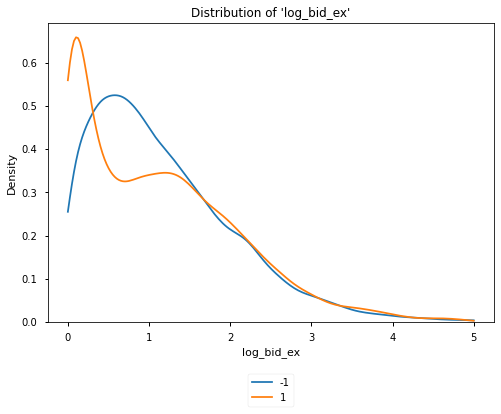

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.0307
Median value of sells =  0.9933
Median value of buys =  0.9746


In [87]:
plot_kde_target("log_bid_ex", clip=[0, 5])


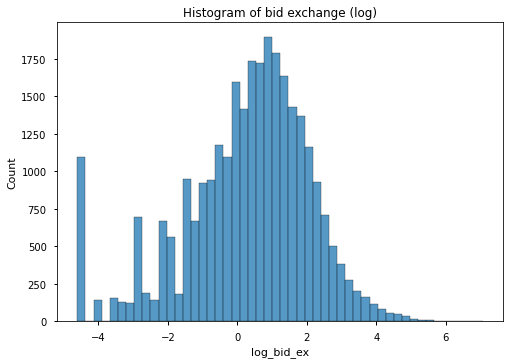

In [88]:
const = 1e-2
data["log_bid_ex"] = np.log(data["bid_ex"] + const)
ax = sns.histplot(data, x="log_bid_ex", bins=50)  # type: ignore
ax.title.set_text("Histogram of bid exchange (log)")


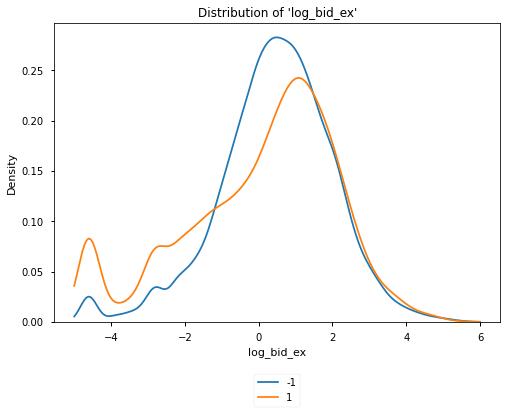

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.1048
Median value of sells =  0.5365
Median value of buys =  0.5068


In [89]:
plot_kde_target("log_bid_ex", clip=[-5, 6])


**Observation:**
- One can choose different constants, but small constants, e. g., `const=1e-2` gives fuzzy, yet distributions that are easier to distinguish. Also note the higher correlation with the target. 
- `TODO:` Look up typical constants to motivate the chosen constant in paper

**Observation:**
- log on size seems to worsen results.
- `TODO:` investigate further, what the reason is. e. g., how many outliers...

# NaNs 🪲

In [90]:
def visualize_nan():
    """
    Visualize NaN values in a heatmap to learn about patterns.
    """
    plt.subplots()
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Missing values (colored in bright beige)")
    plt.show()


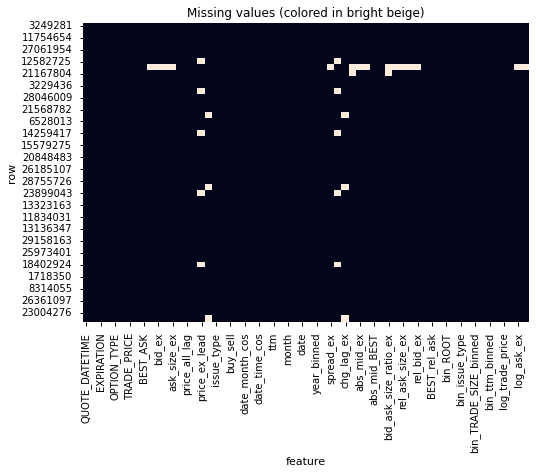

In [91]:
visualize_nan()


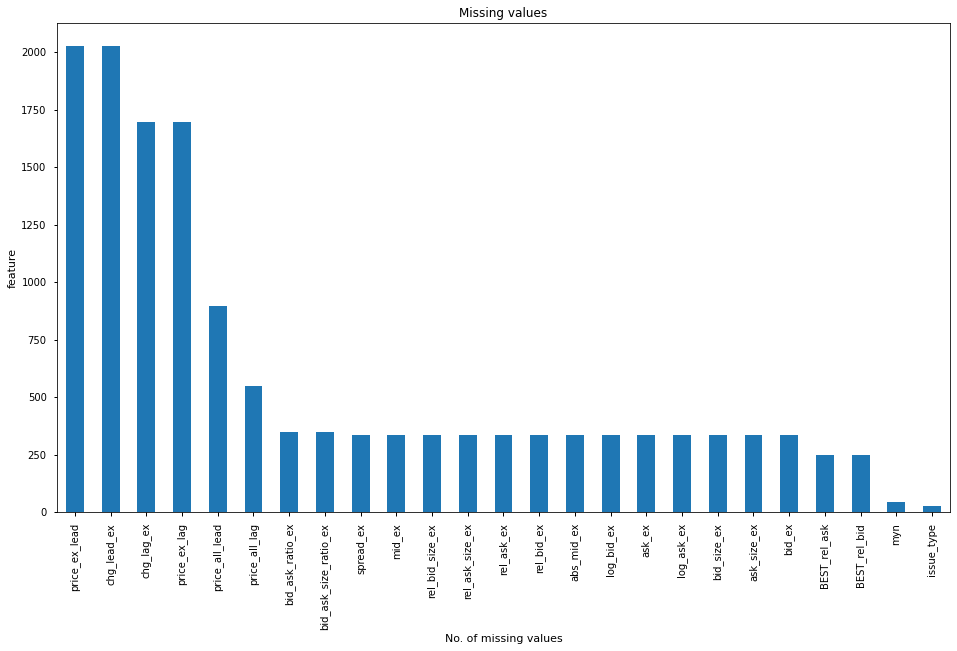

In [92]:
isna_vals = data.isna().sum().sort_values(ascending=False)
isna_vals = isna_vals.loc[lambda x: x > 0]

ax = isna_vals.T.plot(
    kind="bar",
    figsize=ratio,
    legend=False,
    xlabel="No. of missing values",
    ylabel="feature",
    title="Missing values",
)


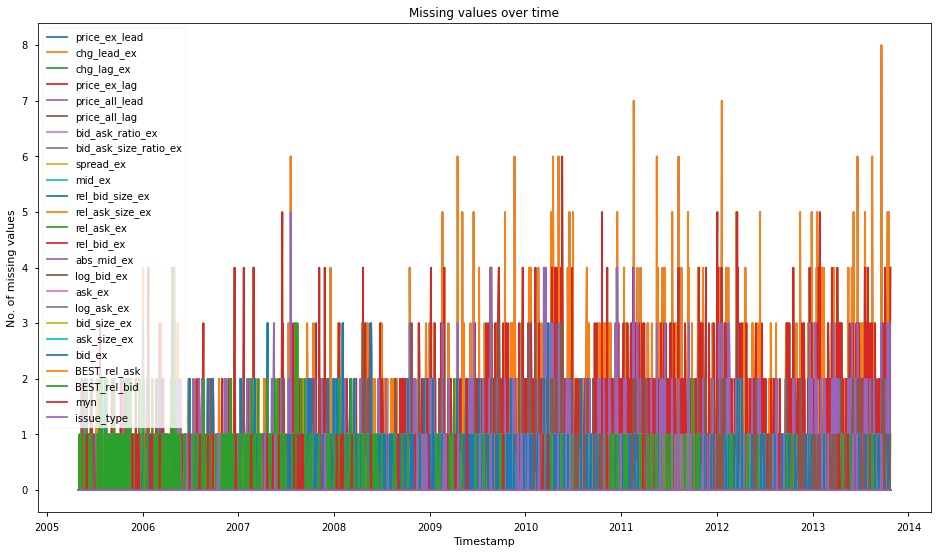

In [93]:
isna_vals_over_time = (
    data[isna_vals.index.tolist()]
    .groupby(data["QUOTE_DATETIME"].dt.date)
    .agg(lambda x: x.isnull().sum())
)
isna_vals_over_time.plot(
    kind="line",
    figsize=ratio,
    title="Missing values over time",
    xlabel="Timestamp",
    ylabel="No. of missing values",
)


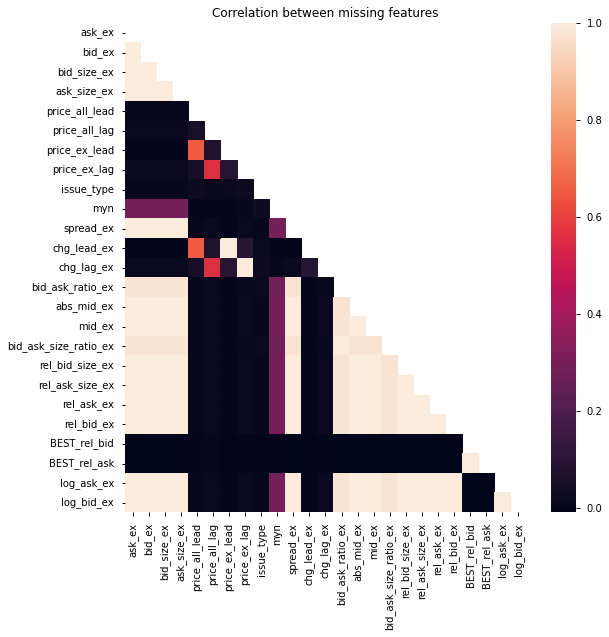

In [94]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

isna_data = data.iloc[
    :, [i for i, n in enumerate(np.var(data.isnull(), axis="rows")) if n > 0]
]

corr_mat = isna_data.isnull().corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9, 9))
ax = sns.heatmap(corr_mat, mask=mask, annot=False, annot_kws={"size": 10}, ax=ax)
ax.title.set_text("Correlation between missing features")


In [95]:
# TODO: Check if there is a pattern between the missing values


**Observation:**
- Note that also important features like `price_all_lead` or `price_ex_lag` are missing. This has an impact, whether it is possible to calculate the classical rules like the trade rule. Consider this when reporting results.
- Missing values become more of a problem towards the end of the data set. At the same time the number of trades also increases.

# Correlations of engineered features 🎲

### Correlations 🎲

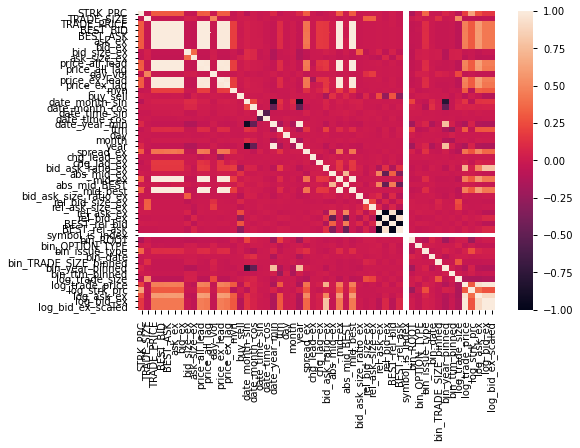

In [135]:
corr = data.corr()

sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)  # type: ignore


### Correlation with target 🎲

In [136]:
sort_criteria = corr["buy_sell"].abs().sort_values(ascending=False)
corr_target = corr.sort_values("buy_sell", ascending=False)["buy_sell"]
corr_target.loc[sort_criteria.index].to_frame()


,buy_sell
buy_sell,1.000000
BEST_rel_bid,0.287257
BEST_rel_ask,-0.287257
rel_ask_ex,0.251699
rel_bid_ex,-0.251698
bid_ask_ratio_ex,-0.157356
abs_mid_ex,0.133812
log_bid_ex_scaled,-0.104815
log_bid_ex,-0.104815
abs_mid_BEST,0.091428


In [98]:
# adapted from here: https://www.kaggle.com/code/willkoehrsen/featuretools-for-good

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.975)]

print(to_drop)


['BEST_BID', 'BEST_ASK', 'ask_ex', 'bid_ex', 'price_all_lead', 'price_all_lag', 'price_ex_lead', 'price_ex_lag', 'year', 'mid_ex', 'mid_best', 'rel_bid_ex', 'BEST_rel_ask', 'log_bid_ex']


**Observation:**
- Newly engineered features have a high correlation with the target, which is positive. Investigate if the correlation is due to randomness or whether a pattern is observable.
- `_ex` and `BEST_` features seem to be rather redundant, even if a high threshold for correlation is chosen.

### Collinearity of features🎲

In [99]:
# Set the threshold
threshold = 0.975

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corr:
    above_threshold_vars[col] = list(corr.index[corr[col] > threshold])

pd.Series(above_threshold_vars)


STRK_PRC                                                        [STRK_PRC]
TRADE_SIZE                                                    [TRADE_SIZE]
TRADE_PRICE              [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
BEST_BID                 [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
BEST_ASK                 [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
ask_ex                   [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
bid_ex                   [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
bid_size_ex                                                  [bid_size_ex]
ask_size_ex                                                  [ask_size_ex]
price_all_lead           [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
price_all_lag            [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
day_vol                                                          [day_vol]
price_ex_lead            [TRADE_PRICE, BEST_BID, BEST_ASK, ask_ex, bid_...
price_ex_lag             

# Analyses of engineered features

In [100]:
corr_target.loc[sort_criteria.index].to_frame().T


,buy_sell,BEST_rel_bid,BEST_rel_ask,rel_ask_ex,rel_bid_ex,bid_ask_ratio_ex,abs_mid_ex,log_bid_ex,abs_mid_BEST,rel_bid_size_ex,...,price_all_lag,price_ex_lag,ask_ex,mid_ex,bid_ex,BEST_BID,mid_best,BEST_ASK,price_all_lead,symbol_is_index
buy_sell,1.0,0.287257,-0.287257,0.251699,-0.251698,-0.157356,0.133812,-0.104815,0.091428,0.084983,...,0.000816,-0.000684,0.000223,0.000212,0.0002,-0.00002,-0.000019,-0.000018,0.000012,NaN


### What works ✔️

#### Trade price vs distance from mid to ask

Similar to `EMO`, where the applied rule depends on whether the trade is at the ask or bid. Similarily `CLVN` uses percentage bounds e. g., $~20~\%$ of spread.

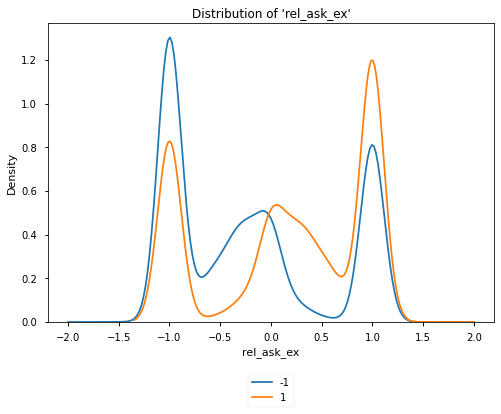

The correlation between 'rel_ask_ex' and the 'buy_sell' is  nan
Median value of sells = -0.3333
Median value of buys =  0.3333


In [101]:
plot_kde_target("rel_ask_ex", clip=[-2, 2])


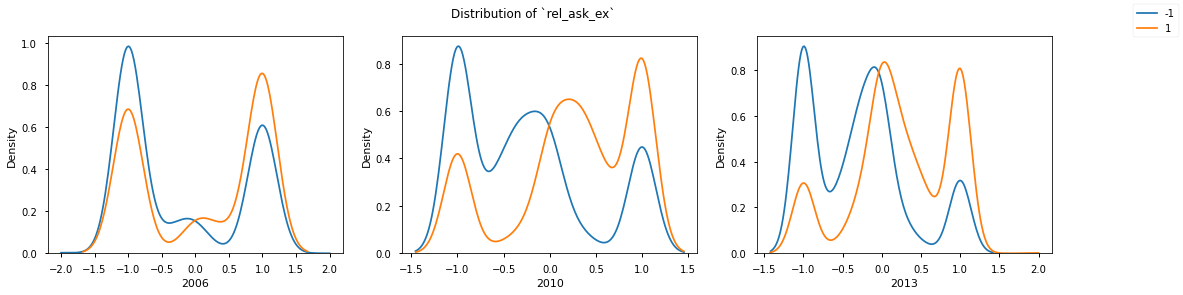

In [102]:
plot_kde_target_comparsion("rel_ask_ex", years=[2006, 2010, 2013], clip=[-2, 2])


#### Depth

Implicitly used in depth rule. Depth rule would assign a buy if `bid_ask_size_ratio_ex` is above one and a sell if it is below zero. But only used for mid-spread trades.

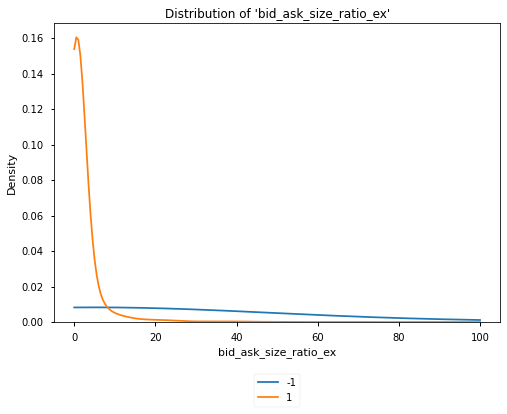

The correlation between 'bid_ask_size_ratio_ex' and the 'buy_sell' is -0.0811
Median value of sells =  1.3444
Median value of buys =  0.5602


In [129]:
plot_kde_target("bid_ask_size_ratio_ex", clip=[0, 100])


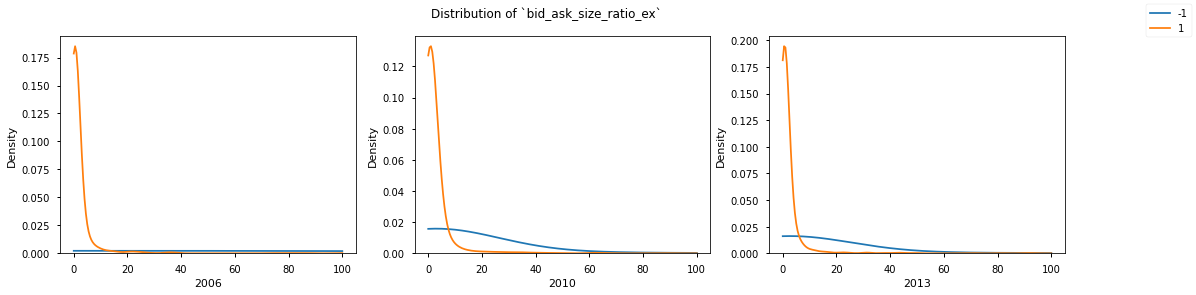

In [130]:
plot_kde_target_comparsion("bid_ask_size_ratio_ex", years=[2006, 2010, 2013], clip=[0, 100])


#### $\log$ bid ex

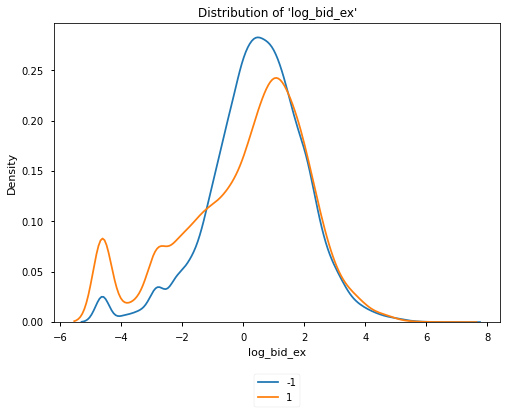

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.1048
Median value of sells =  0.5365
Median value of buys =  0.5068


In [105]:
plot_kde_target("log_bid_ex")


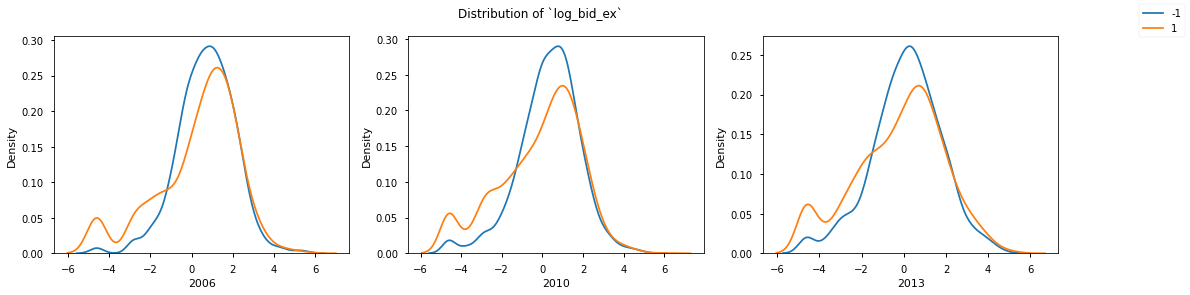

In [106]:
plot_kde_target_comparsion("log_bid_ex", years=[2006, 2010, 2013])


**Observation:**
- Application of the $\log$ leads to highly differentiable distributions, that remain stable over time.

#### $\log$ trade price

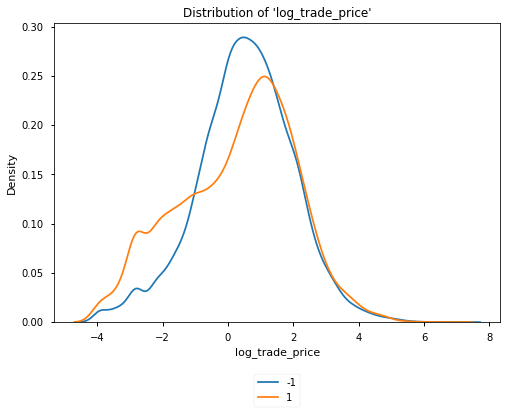

The correlation between 'log_trade_price' and the 'buy_sell' is -0.0759
Median value of sells =  0.5653
Median value of buys =  0.5596


In [107]:
plot_kde_target("log_trade_price")


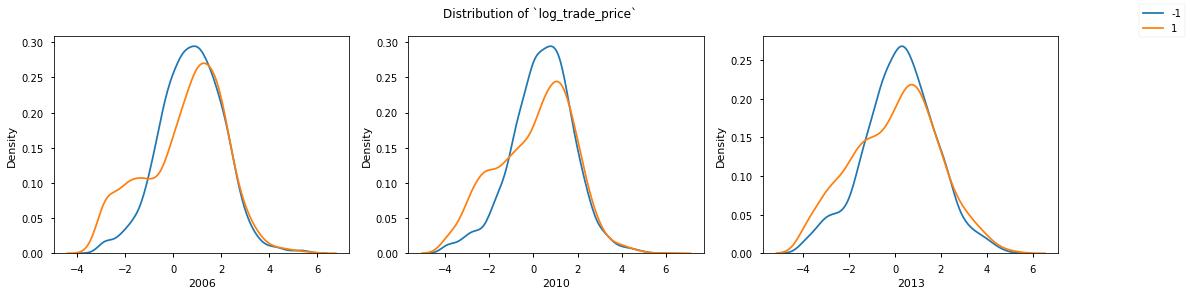

In [108]:
plot_kde_target_comparsion("log_trade_price", years=[2006, 2010, 2013])


**Observation:**
- Application of the $\log$ leads to highly differentiable distributions, that remain stable over time.

#### Ask size

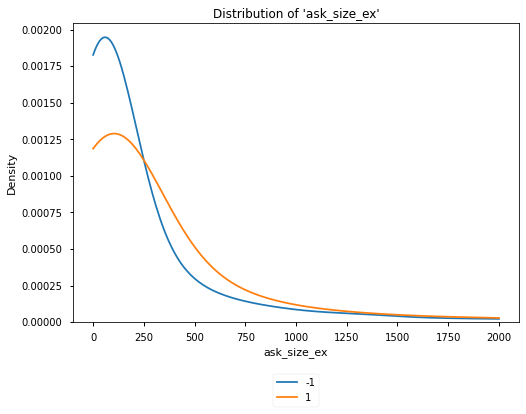

The correlation between 'ask_size_ex' and the 'buy_sell' is  0.0459
Median value of sells =  60.0000
Median value of buys =  102.0000


In [109]:
plot_kde_target("ask_size_ex", clip=[0, 2000])


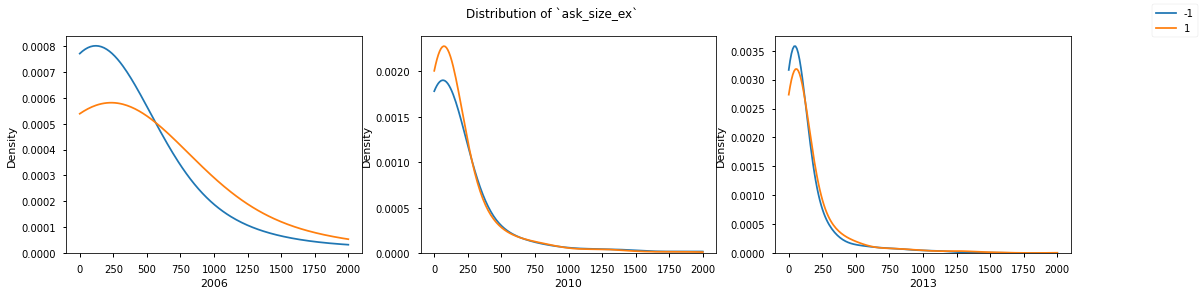

In [110]:
plot_kde_target_comparsion("ask_size_ex", years=[2006, 2010, 2013], clip=[0, 2000])


#### Bid size

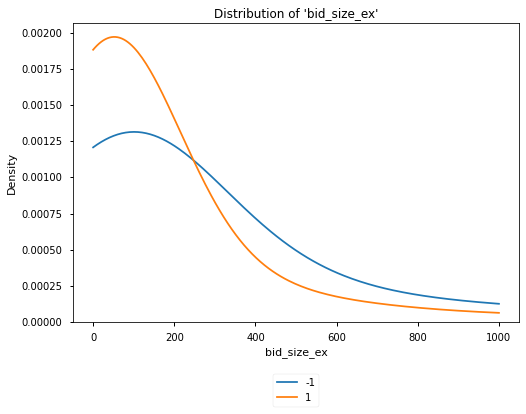

The correlation between 'bid_size_ex' and the 'buy_sell' is -0.0577
Median value of sells =  102.0000
Median value of buys =  45.0000


In [111]:
plot_kde_target("bid_size_ex", clip=[0, 1000])


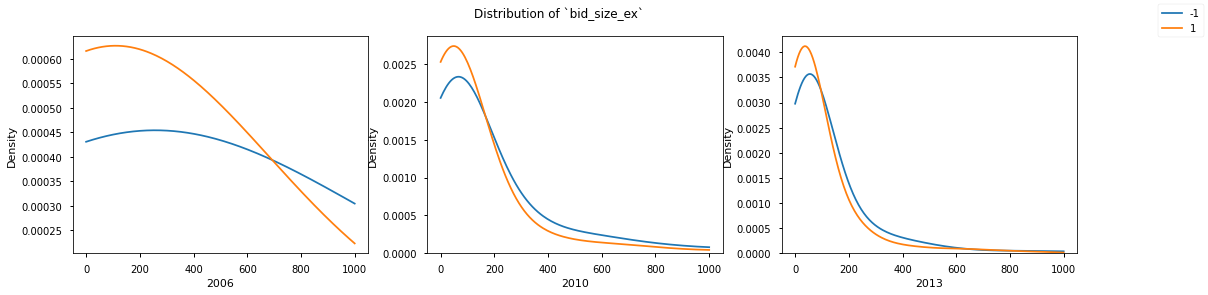

In [112]:
plot_kde_target_comparsion("bid_size_ex", years=[2006, 2010, 2013], clip=[0, 1000])


#### Quote rule

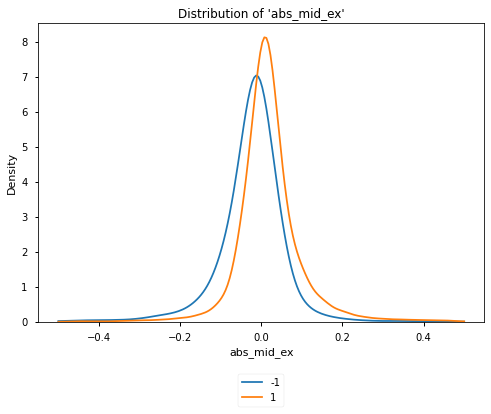

The correlation between 'abs_mid_ex' and the 'buy_sell' is  0.1338
Median value of sells = -0.0150
Median value of buys =  0.0100


In [113]:
plot_kde_target("abs_mid_ex", clip=[-0.5, 0.5])


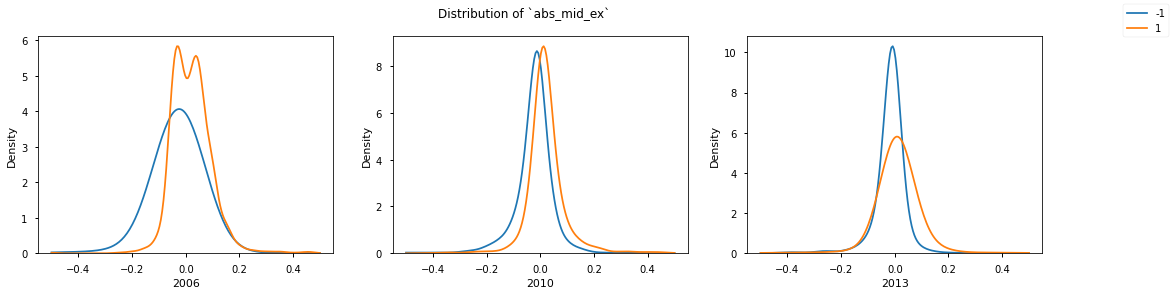

In [114]:
plot_kde_target_comparsion("abs_mid_ex", years=[2006, 2010, 2013], clip=[-0.5, 0.5])


**Observation:**
- Compared with tick rule or reverse tick rule, quote rule is the only classical rule, where distributions are somewhat distinguishable
- On can clearly see that the quote rule works better at the beginning of the data set and its performance worsens over time.

#### Day of the month

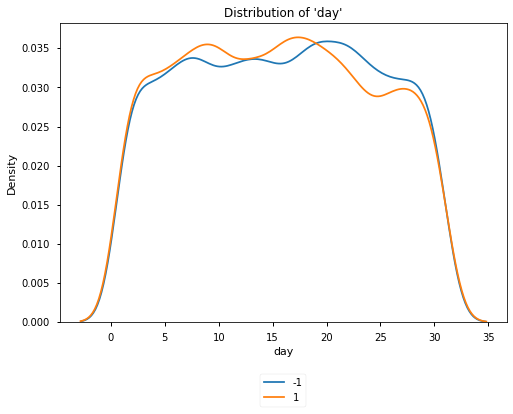

The correlation between 'day' and the 'buy_sell' is -0.0180
Median value of sells =  16.0000
Median value of buys =  15.0000


In [115]:
plot_kde_target("day")


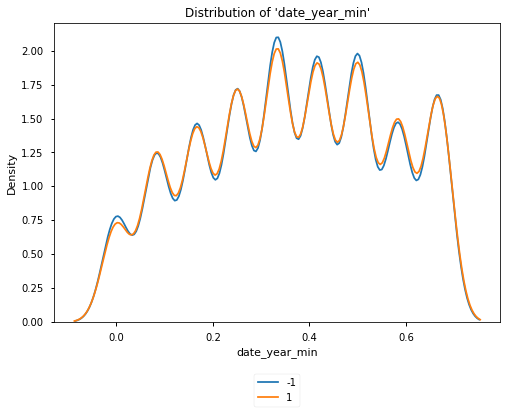

The correlation between 'date_year_min' and the 'buy_sell' is  0.0027
Median value of sells =  0.3333
Median value of buys =  0.3333


In [116]:
plot_kde_target("date_year_min")


**Observation:**
* Judging from the plot there seems to be a seasonal pattern e. g., more buys 
at the beginning of the month and more sells towards the end of the month. 
* Due to the distributions it could make sense to include date features in some feature sets. But do not include in the most basic data set.

## What doesn't ❌

#### tick rule

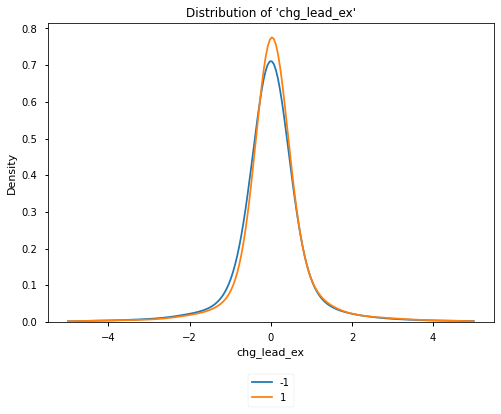

The correlation between 'chg_lead_ex' and the 'buy_sell' is  0.0184
Median value of sells =  0.0100
Median value of buys =  0.0200


In [117]:
plot_kde_target("chg_lead_ex", clip=[-5, 5])


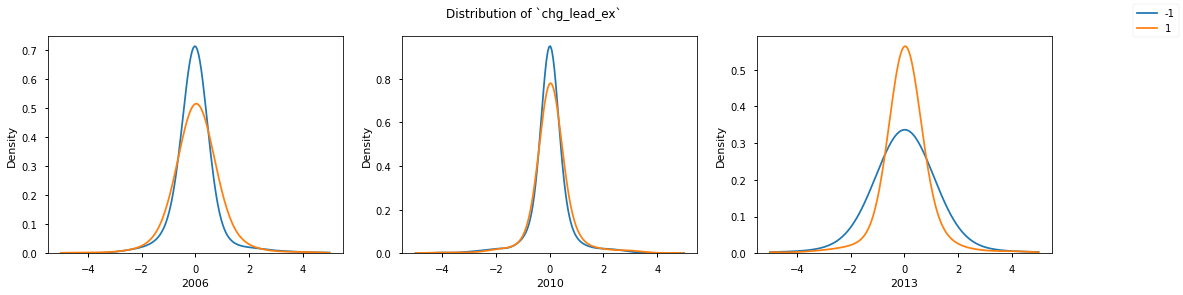

In [118]:
plot_kde_target_comparsion("chg_lead_ex", years=[2006, 2010, 2013], clip=[-5, 5])


**Observation:**
- Distributions are hardly distinguishable. 
- Results seem to worsen over time, which is consistent to the observations of Grauer et. al.

#### reverse tick rule

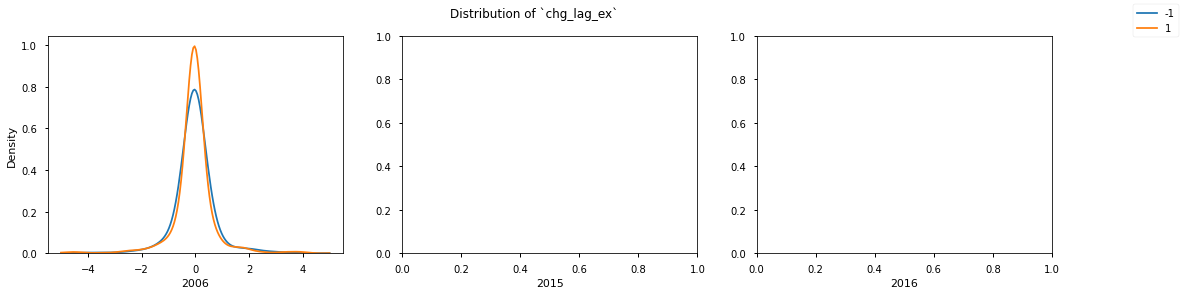

In [119]:
plot_kde_target_comparsion("chg_lag_ex", years=[2006, 2015, 2016], clip=[-5, 5])


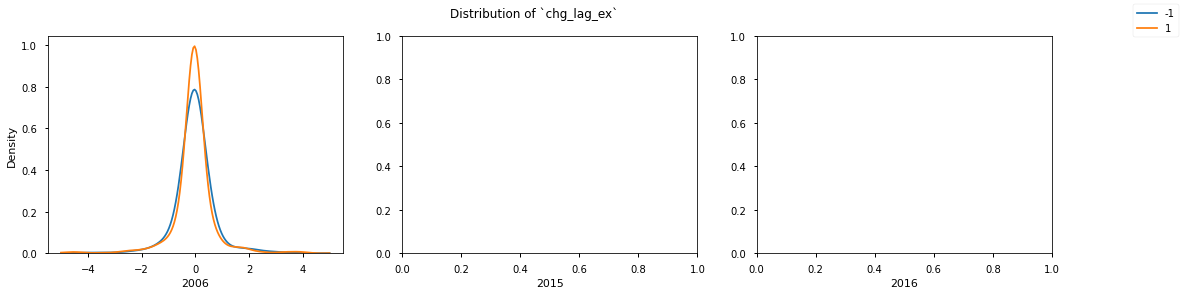

In [120]:
plot_kde_target_comparsion("chg_lag_ex", years=[2006, 2015, 2016], clip=[-5, 5])


**Observation:**
- Distributions are hardly distinguishable. 
- Results worsen over time.

# Impact of scaling 🔢

In [121]:
from sklearn.preprocessing import StandardScaler

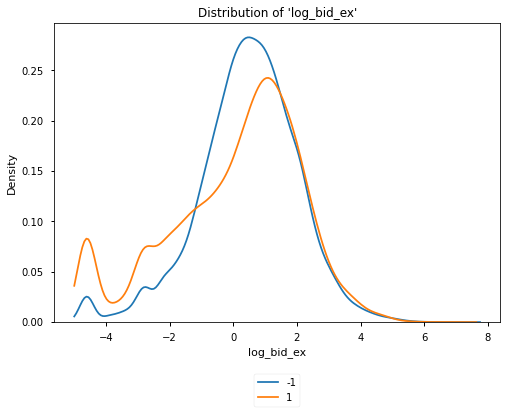

The correlation between 'log_bid_ex' and the 'buy_sell' is -0.1048
Median value of sells =  0.5365
Median value of buys =  0.5068


In [122]:
plot_kde_target("log_bid_ex", clip=[-5,8])

In [123]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [124]:
scaler = StandardScaler()
data["log_bid_ex_scaled"] = scaler.fit_transform(X=data["log_bid_ex"].values.reshape(-1,1))

In [125]:
data["log_bid_ex_scaled"].describe()

count    2.917400e+04
mean     3.969921e-17
std      1.000017e+00
min     -2.668321e+00
25%     -5.199704e-01
50%      1.346570e-01
75%      6.709865e-01
max      3.713296e+00
Name: log_bid_ex_scaled, dtype: float64

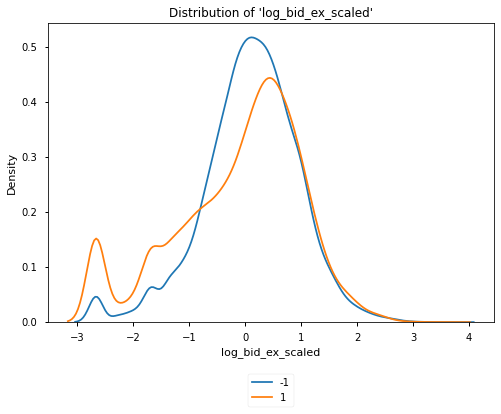

The correlation between 'log_bid_ex_scaled' and the 'buy_sell' is -0.1048
Median value of sells =  0.1411
Median value of buys =  0.1249


In [126]:
plot_kde_target("log_bid_ex_scaled", clip=[-5,5])

# Cross-validation⛑️

In [ ]:
def transform(df:pd.DataFrame)->Tuple[pd.DataFrame, pd.Series]:

  x = 

  y = df["buy_sell"]

  return x, y



In [ ]:
train = pd.read_parquet("gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet")
x_train, y_train = transform(train)

del train

In [ ]:
val = pd.read_parquet("gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet")
x_val, y_val = transform(val)

del val

In [ ]:
test= pd.read_parquet("gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_extended_20.parquet")
x_test, y_test = transform(test)

del test

In [ ]:
from catboost import cv

# parameters for training inside cv:
params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

results = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False,
    return_models=True
)

In [143]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 120.1 MB/s 


In [146]:
from catboost import Pool, cv

cv_data = [["France", 1924, 44],
           ["USA", 1932, 37],
           ["Switzerland", 1928, 25],
           ["Norway", 1952, 30],
           ["Japan", 1972, 35],
           ["Mexico", 1968, 112]]

labels = [1, 1, 0, 0, 0, 1]

cv_dataset = Pool(data=cv_data,
                  label=labels,
                  cat_features=[0])

params = {"iterations": 100,
          "depth": 2,
          "loss_function": "Logloss",
          "verbose": False,
          "roc_file": "roc-file"}

results, models = cv(cv_dataset,
            params,
            fold_count=2, return_models=True)
print(results)

print(models)

Training on fold [0/2]

bestTest = 0.5738373179
bestIteration = 84

Training on fold [1/2]

bestTest = 0.693188484
bestIteration = 0

    iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0            0           0.689013          0.005904            0.681549   
1            1           0.685340          0.011887            0.660894   
2            2           0.685858          0.012818            0.641069   
3            3           0.685975          0.023640            0.629656   
4            4           0.686613          0.024923            0.612977   
..         ...                ...               ...                 ...   
95          95           0.863043          0.402531            0.123702   
96          96           0.866321          0.406193            0.122224   
97          97           0.869681          0.409679            0.120777   
98          98           0.873030          0.413121            0.119361   
99          99           0.874569        

In [150]:
for model in models:
  feature_importance = model.get_feature_importance(prettified=True)

In [158]:
feature_importance
bar = feature_importance.copy()


foo = feature_importance.copy()
foo = foo.add_prefix("a_")

print(pd.concat([bar, foo], axis=1))

  Feature Id  Importances a_Feature Id  a_Importances
0          2     89.95811            2       89.95811
1          1     10.04189            1       10.04189
2          0      0.00000            0        0.00000


In [ ]:
def evaluate(x:pd.DataFrame, y:pd.Series, features:List[str], cat_features:List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

  cv_dataset = Pool(data=x[features],
                    label=y,
                    cat_features=cat_features)

  params = {
            "od_type": "Iter",
            "logging_level": "Silent",
            "depth":8,
            "loss_function": "Logloss",
            "task_type": "GPU",
            "cat_features": cat_features,
            "random_seed": 42,
  }
  # define features

  cv_results, models = cv(cv_dataset,
            params,
            fold_count=2, return_models=True)

  oos_results = []
  feature_importances = []
  for i, model in enumerate(models):
    oos_results.append([i, model.score(x_train[features],y_train), model.score(x_val[features], y_val), model.score(x_test[features], y_test)])
    
    feature_importance = model.get_feature_importance(prettified=True).add_prefix(f"fold_{i}_")
    feature_importances.append(feature_importance)
  
  results_oos = pd.DataFrame(data = oos_results, columns=["fold", "acc_train", "acc_val","acc_test"])
  results_fi = pd.concat(feature_importances, axis=1)

  return cv_results, oos_results, results_fi

In [127]:
# TODO: Perform cross-validation
# https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook


# Conclusion 🔗

**Observation:**
- log on size seems to worsen results, but improves results for prices
- `TODO:` investigate further, what the reason is. e. g., some skewness, but outliers...
- `TODO:` investigate further, if there is an economic intuition behind it
- Classical features have hardly any importance. But keep them for comparsion
- Features of Grauer et. al seem to work
- Binning gives mixed results e. g., for trade size and ttm
- `TODO:` update [feature proposal](https://github.com/KarelZe/thesis/blob/main/references/obsidian/%F0%9F%8D%ACImplementation/%F0%9F%A7%AAFeature%20Engineering/%F0%9F%A7%83Feature%20Sets.md) accordingly
- `TODO:` Correlation is a common method for feature selection https://en.wikipedia.org/wiki/Feature_selection#Filter_method
- `TODO:` Perform cross-validation and calculate AUC on train, validation and test set
- `TODO:` Remove highly correlated columns if possible
- `TODO:` Results are not suprising, when compared with feature importances of first gbm (taken from [this notebook](https://github.com/KarelZe/thesis/blob/d0e078a8030e1ba47b761b4a1abfc699a629ca0a/notebooks/3.0-mb-feature_engineering_baseline.ipynb)):
```
UNDERLYING_SYMBOL 0.021566366629726046
STRK_PRC 0.009127319935855806
OPTION_TYPE 0.005046634536154527
TRADE_SIZE 0.02387199423754382
TRADE_PRICE 0.005713157136252193
BEST_BID 0.021382350572243275
BEST_ASK 0.010634148143876284
ask_ex 0.02105069450386549
bid_ex 0.004026117456655969
bid_size_ex 0.15678191442629613
ask_size_ex 0.14079564200719413
price_all_lead 0.007502007413328573
price_all_lag 0.0006435968556699435
day_vol 0.07305687183934556
price_ex_lead 0.0012276493027704556
price_ex_lag 0.0015678783924615502
time_to_maturity 0.024955327521460076
date_month_sin 0.028046528183426834
date_month_cos 0.0178607911888709
mid_ex 0.0012948919276966858
abs_mid_ex 0.28364371496098023
rel_bid_size_ex 0.07208704474907267
rel_ask_size_ex 0.06640793782355861
sgn_chg_ex_lead 0.0017094202556935758
```